# **MIE1513: Final Project**
### Submission date: April 20, 2020 at 23:59pm

-------------

## Academic Integrity Declaration:
In submitting this assessment, I confirm that my conduct during this project adheres to the Code of Behaviour on Academic Matters. I confirm that I have not acted in such a way that would constitute cheating, misrepresentation, or unfairness, including but not limited to, using unauthorized aids and assistance, impersonating another person, and committing plagiarism. I pledge upon my honour that I have not violated the Faculty of Applied Science & Engineering’s Honour Code during this assessment.

-------------


# Part 1: Data Loading

### (a) Load the provided dataset (reddit_data.json)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re, nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')  
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer 
from nltk import bigrams, trigrams, ngrams
from nltk import tokenize
import re
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import itertools
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import operator


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
data_all = pd.read_json("reddit_data.zip", orient='records', lines=True)
data_all = data_all[["id", "author", "created_utc", "subreddit", "title", "num_comments", "score", "selftext", "url"]]

In [3]:
data_all.head()

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
0,abcupx,WithGravy,1546300839,gaming,What are some game games to enjoy on a low-end...,31,3,Got a new laptop and want to enjoy some games ...,https://www.reddit.com/r/gaming/comments/abcup...
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
2,abcv1a,[deleted],1546300892,worldnews,"India: Chinese woman, 25, on solo trip to Khaj...",13,23,,https://timesofindia.indiatimes.com/city/agra/...
3,abcv5v,Lucious-Lyon,1546300914,AskReddit,[Serious] American Liberals of Reddit: Without...,76,0,[removed],https://www.reddit.com/r/AskReddit/comments/ab...
4,abcv7f,sandollars,1546300923,worldnews,"According to the Fiji Government, the Australi...",21,13,,http://fijisun.com.fj/2019/01/01/vuniwaqa-prak...


### (b)	Generate your unique subset of the data

**Make sure you update unique_string with your email address**

In [0]:
# DO NOT CHANGE THE FUNCTION BELOW
def getMySubreddits(data, my_str):
    assert my_str != "", "You must fill in your unique string"
    import random
    subreddits = sorted(data["subreddit"].unique().tolist())
    rng = random.Random(my_str)
    return rng.sample(subreddits, 4)

In [5]:
# Fill in your UofT email in the variable unique_string below
unique_string = "jasonq.zhang@mail.utoronto.ca" 
my_subreddits = getMySubreddits(data_all, unique_string)
print("My subreddits:", my_subreddits)

My subreddits: ['pics', 'funny', 'Games', 'Android']


In [0]:
data = data_all[data_all["subreddit"].isin(my_subreddits)]

In [7]:
data

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg
5,abcv7e,RyanGwood12,1546300923,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg
13,abcvty,popedotninja,1546301036,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg
14,abcvv8,[deleted],1546301042,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg
20,abcwfb,wearestardust24,1546301142,pics,Adult male polar bear. Photo: Paul Nicklen,4,69,,https://i.redd.it/jzyd4nhodp721.jpg
...,...,...,...,...,...,...,...,...,...
226198,alvrk1,Big_Ballzz,1548978501,funny,Jason Momoa is a perfect fit,357,11537,,https://v.redd.it/xem2scboiud21
226208,alvs8j,boostdtalon,1548978717,funny,The goalie for our neighborhood street hockey ...,10,48,,https://i.redd.it/jk4mu1v5jud21.jpg
226210,alvsce,dpm25,1548978767,Android,I have a note 10.1 (2012) can I use a 30 pin t...,2,1,[removed],https://www.reddit.com/r/Android/comments/alvs...
226213,alvsjx,zaquerie,1548978846,funny,The perfect photobomb doesn’t exis—,326,9483,,https://i.redd.it/haggl69ujud21.jpg


In [8]:
# 33,022 total number of posts with 8 feature sets and one target set
data.shape

(33022, 9)

# Part 2: Exploratory Data Analysis 

To prepare for the classification of subreddit labels in part 3, we need to better understand the importance of each column, as well to explore ways to improve a feature's importance. Therefore, a thorough EDA will be performed for each column, as shown in the following sections.

##a) Identifying Feature Importance

### 2.1 Exploring Subreddits

Let's for look at the target column which is the subreddit classes.

Text(0, 0.5, 'Subreddit Label')

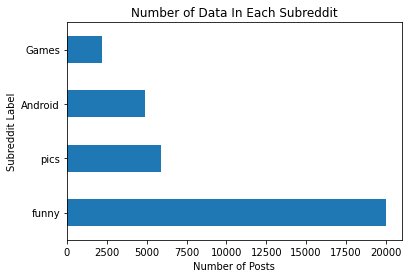

In [9]:
# number of posts under each subreddit
data.groupby('subreddit')['id'].count().sort_values(ascending=False).plot(kind='barh')
plt.title('Number of Data In Each Subreddit')
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit Label')

As seen the plot above, the dataset is quite imbalanced, with a majority of data being in the 'funny' subreddit. 

Next, looking at the outlier distribution of the columns 'score' and 'num_comments':

Text(0.5, 1.0, 'Score Distribution of Reddit Posts for Each Subreddit')

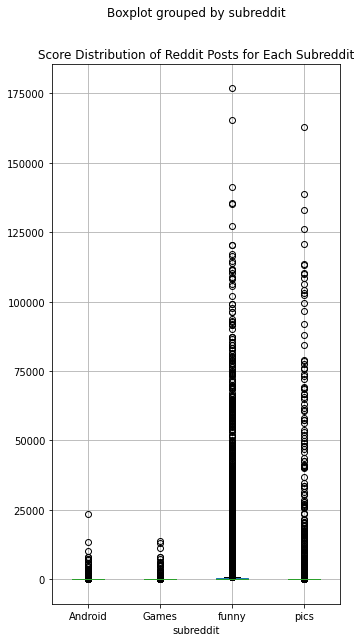

In [10]:
data.boxplot(column='score', by='subreddit', figsize=(5,10))
plt.title('Score Distribution of Reddit Posts for Each Subreddit')

Text(0.5, 1.0, 'Distribution of Number of Comments of Reddit Posts for Each Subreddit')

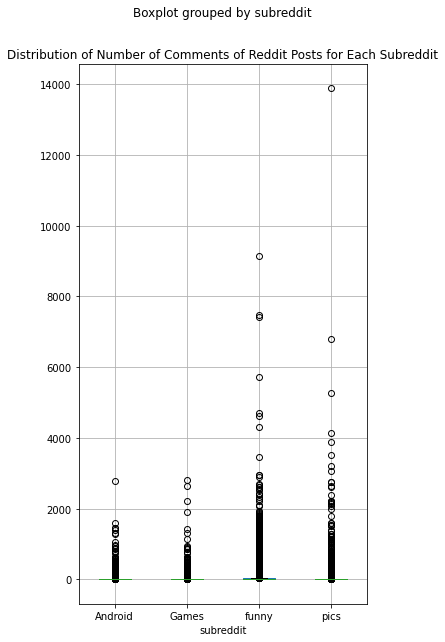

In [11]:
data.boxplot(column='num_comments', by='subreddit', figsize=(5,10))
plt.title('Distribution of Number of Comments of Reddit Posts for Each Subreddit')

Both the score and num_comments have a large amount and extent of outliers, with the mean at around zero, for all subreddits. This means that most of the posts have little to no interactions by other redditors. High score/number of comments indicate high engagement by users. Outliers of the subreddits 'funny' and 'pics' have much higher values than the other two, in terms of both score and num_comments.

###2.2 Exploring Author Information




To begin the EDA of the feature set, we will first look at the author information, which is the username that has created the post. The author of the post will give us insight with regards to posts that have been created by the same authors, as well as how posts by an author can be indicative of the subreddit class. 

Note that the author '[deleted]' is a clusterization of many authors whose post has been deleted and therefore will not be included in the analysis of author information.

Looking at the number of unique authors:

In [12]:
# number of unique authors
len(list(data.author.unique()))

18724

Next, looking at the authors with the most number of posts:

In [0]:
# top 50 authors with the most posts
top50author = data.groupby('author')['author'].count().sort_values(ascending=False)[:51]
# excluding 'deleted'
top50author = top50author[1:51]

Text(0.5, 1.0, 'Top 50 Users With the Most Number of Posts')

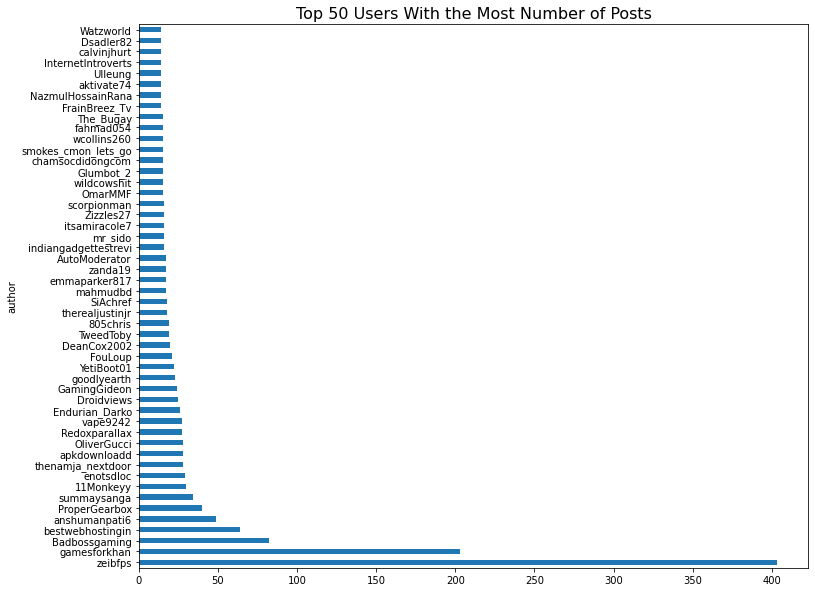

In [14]:
# plotting for top 30 authors with the most posts
top50author.plot(kind='barh', figsize=(12,10))
plt.title('Top 50 Users With the Most Number of Posts', fontsize=16)

From the figure above, we can see that aside from the top 4 authors which have more than 50 posts each ('zeibfps' has over 400 posts), most of the top authors have less than 50 posts each. Considering that this is 1-month of data, this suggests that theses authors post frequently, with a small portion of these authors being extremely active. 

Since these authors account for a great number of posts, they should also be informative when we look the subreddit(s) each of the author frequently post in:

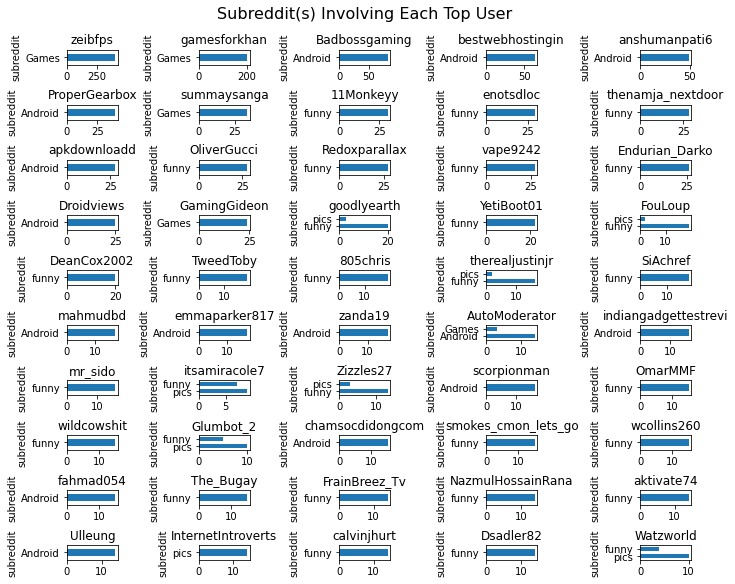

In [15]:
# plotting subreddit(s) each of the top 50 users are involved in
fig, ax = plt.subplots(nrows=10, ncols=5, constrained_layout=True)

i=0
for row in ax:
    for col in row:
        data.loc[data['author']==top50author.index[i]].groupby('subreddit')['author'].count().sort_values(ascending=False).plot(kind='barh', figsize=(10,8), ax=col)
        col.set_title(top50author.index[i])
        i += 1
fig.suptitle('Subreddit(s) Involving Each Top User', fontsize=16)
plt.show()

By examining the subplots above, where each subplot shows the subreddit(s) an author is active in, we can see that the majority of authors only post under one subreddit, with the others posting in two. For example, the user with the most posts ('zeibfps') has over 400 posts which all fall under the 'Games' subreddit. This is suggests that this is a quite active user who only posts gaming contents. 

Mutual information is a useful tool for us to use since it compares the probability distributions of two columns, without constraints on the column value type. We will use normalized MI score (ranging from 0 to 1) for ease of understanding. Let's see how much mutual information exist between the 'author' column and subreddit classes. 

In [16]:
miScore_author = (['author']+[metrics.normalized_mutual_info_score(data['subreddit'], data['author'])])
miScore_author 

['author', 0.18111038243777453]

The column 'author' shares some amount of mutual information with the target column. 

From the results above, it can be said that author information can be quite important when it comes to predicting which subreddit the post falls under, especially for posts by the top authors. 

Next, we will look at the timestamp information ('created_utc') of the posts, and how the time a post has been created can attribute to the author information as well as the subreddit classification. 

###2.3 Exploring UTC Timestamp

The timestamp information is in a unix format, which is simply a string of numbers. Since we know that this information is recorded in terms of UTC (Coordinated Universal Time), we can simply convert the unix timestamp into any time format that we deem is useful for interpretation and analysis. 

First, let's look at column importance from the perspective of mutual information.

In [17]:
miScore_utc = (['created_utc']+[metrics.normalized_mutual_info_score(data['subreddit'], data['created_utc'])])
miScore_utc

['created_utc', 0.18671159375487625]

As seen above, the utc column contains similar amount of correlation as the column 'author'.

Considering that the posts are all from the same month and year (Jan 2019), it wouldn't be meaningful to extract information from this perpective. Since all subreddits have daily influx of new posts, we will instead convert the unix timestamps into distinguishable information such as day/night (AM/PM), hour, and minutes. This way we can observe time information in a more detailed manner. 

As a more general approach, let's first look at the day-of-week information of the posts:

In [18]:
#convert timestamp into day-of-week from 0(sunday) to 6
day = []

for ts in data['created_utc']:

  day.append(int(datetime.utcfromtimestamp(ts).strftime('%w')))

#add to new column in original df
data['day_of_week'] = day

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


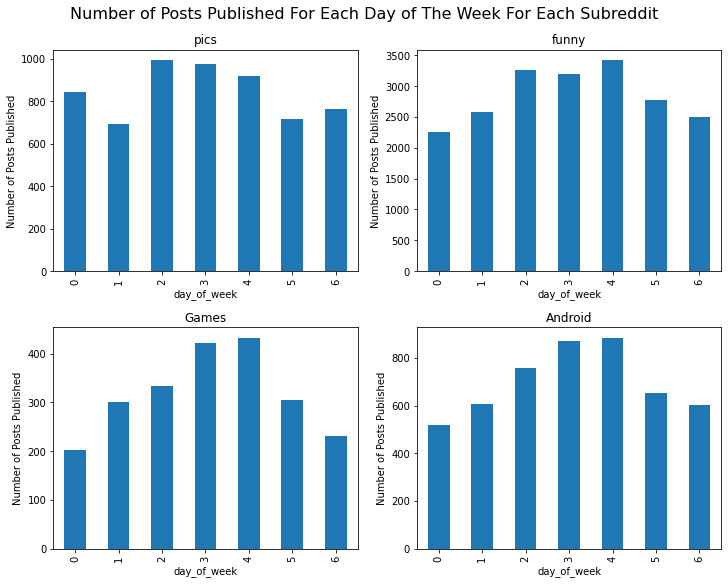

In [19]:
# plotting subreddit(s) each of the top 50 users are involved in
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
for row in ax:
    for col in row:
        data.loc[data['subreddit']==my_subreddits[i]].groupby('day_of_week')['subreddit'].count().plot(kind='bar', figsize=(10,8), ax=col)
        col.set_title(my_subreddits[i])
        col.set_ylabel('Number of Posts Published')
        i+=1

fig.suptitle('Number of Posts Published For Each Day of The Week For Each Subreddit', fontsize=16)
plt.show()

In [20]:
miScore_day_of_week = (['day_of_week']+[metrics.normalized_mutual_info_score(data['subreddit'], data['day_of_week'])])
miScore_day_of_week

['day_of_week', 0.0012097915130469916]

From the subplots shown above, a clear trend cannot be identified when looking at the day-of-week information of a post, since each subreddit has a constant daily influx of new posts, as mentioned before. Worth noting is that for the subreddits of 'funny', 'Games', and 'Android', the number of new posts experience drops in numbers on the weekends (i.e. 0 and 6), with 'Games' experiencing the most significant drops-offs. The mutual information of the 'day-of-week' column is also very low.

Next, let's look at the day-night information of subreddits:

In [21]:
#convert timestamp into AM/PM 
day_night = []

for ts in data['created_utc']:

  # 1 if AM 0 if PM
  day_night.append(1 if datetime.utcfromtimestamp(ts).strftime('%p') == 'AM' else 0)

#add to new column in original df
data['day_night'] = day_night

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


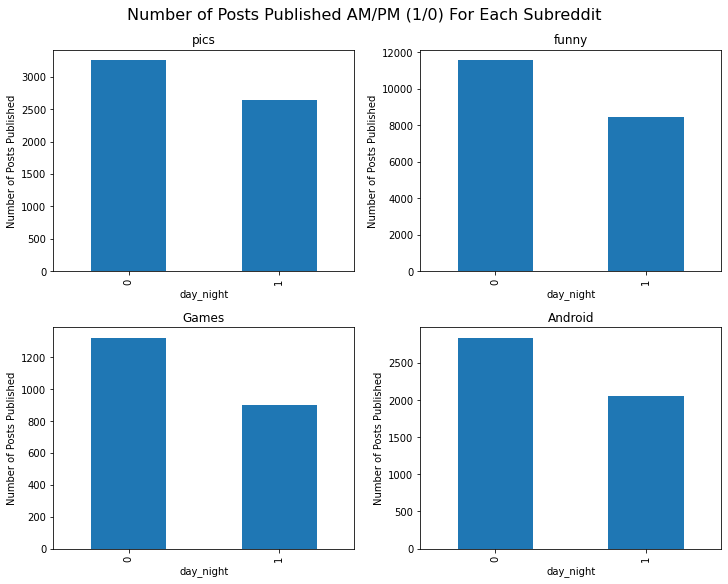

In [22]:
# plotting subreddit(s) each of the top 50 users are involved in
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
for row in ax:
    for col in row:
        data.loc[data['subreddit']==my_subreddits[i]].groupby('day_night')['subreddit'].count().plot(kind='bar', figsize=(10,8), ax=col)
        col.set_title(my_subreddits[i])
        col.set_ylabel('Number of Posts Published')
        i+=1

fig.suptitle('Number of Posts Published AM/PM (1/0) For Each Subreddit', fontsize=16)
plt.show()

From the results presented in the figure above, all subreddits have more new posts posted at night (for UTC time-zone) than during the day. This means that it would not be helpful to directly use the day-night information for classification of the subreddits. 

In terms of mutual information with the target classes:

In [23]:
miScore_daynight = (['day_night']+[metrics.normalized_mutual_info_score(data['subreddit'], data['day_night'])])
miScore_daynight

['day_night', 0.0002962641078619714]

The mutual information of the transformed utc timestamp (day/night) is much lower than the original. Together with the subplots, it can be said that the day/night information is much more correlated to the author of the post than the subreddit classes.

To gather more information which may be used in later feature sets, let's add hour/minute information to the original dataset:

In [24]:
#convert timestamp into hour (12-hour) and minutes
hour = []
minute =[]

for ts in data['created_utc']:

  #hour as decimal
  hour.append(datetime.utcfromtimestamp(ts).strftime('%I'))

  #minute as decimal
  minute.append(datetime.utcfromtimestamp(ts).strftime('%M'))

#add to new column in original df
data['hour'] = hour
data['minute'] = minute

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


###2.4 Exploring Number of Comments

The column 'num_comments' contain information with regards to the number of comments a post receives. First looking at the mutual information of the column:

In [25]:
miScore_comments = (['num_comments']+[metrics.normalized_mutual_info_score(data['subreddit'], data['num_comments'])])
miScore_comments

['num_comments', 0.21130048903056672]

The mutual information score of the number of comments is higher than the author and timestamp information of the post. 

From the perspective of a post's popularity, the number of comments a post receives is a great indicator of the popularity of the post. The number of posts for each subreddit vary greatly (from under 2500 to over 20,000). Therefore we should not directly compare the number of comments to each subreddit class, since a subreddit with significantly more posts will have more comments. Instead, we will look at whether or how the number of comments is correlated to the top authors with the highest number of posts. 

Text(0.5, 0, 'Number of Comments')

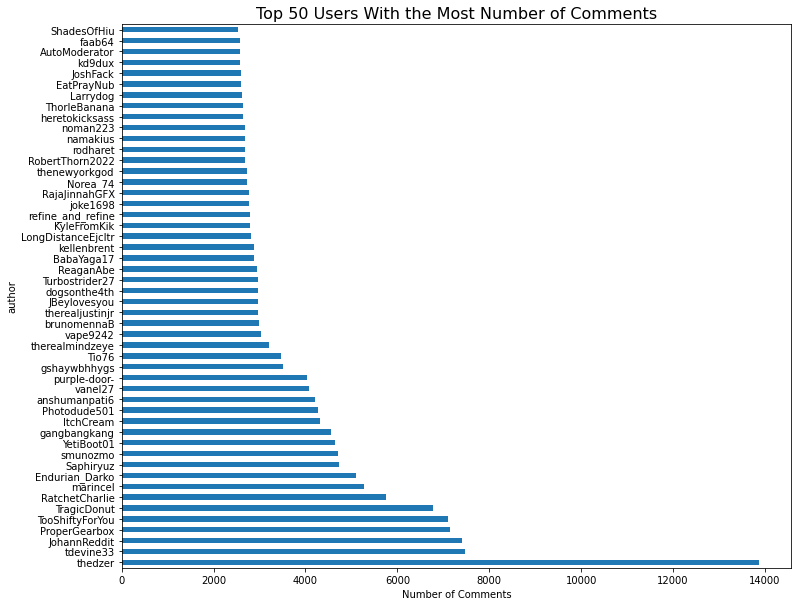

In [26]:
#top 50 authors by number of comments
top50author_comments = data.groupby('author')['num_comments'].sum().sort_values(ascending=False).sort_values(ascending=False)[1:51]
top50author_comments.plot(kind='barh', figsize=(12,10))
plt.title('Top 50 Users With the Most Number of Comments', fontsize=16)
plt.xlabel('Number of Comments')

In [27]:
#authors shared by both top author lists (based on number of comments and number of posts)
[author for author in top50author_comments.index if author in top50author.index]

['ProperGearbox',
 'Endurian_Darko',
 'YetiBoot01',
 'anshumanpati6',
 'vape9242',
 'therealjustinjr',
 'AutoModerator']

In [28]:
#author with the most number of comments
top50author_comments.index[0], top50author_comments[0]

('thedzer', 13880)

In [29]:
#number of posts by this author
data.loc[data['author']==top50author_comments.index[0]].groupby('author')['author'].count()

author
thedzer    1
Name: author, dtype: int64

As seen above, only 7 of the top 50 authors with the most number of posts are listed within the top 50 authors with the most number of comments. This suggests that the popularity of a post (based on number of comments) is not necessarily correlated with whether or not the author of the post is very active, but with whether the content of the post has gone 'viral'. For example, the author with the highest number of comments (nearly 14,000) has only one post, suggesting that the post contains viral content which has gained sudden popularity. 

This indicates the importance of incorporating the concept of virality into subreddit classifications from the perspective of a post's popularity. To do so, we will first need to perform an analysis on the score (sum of 'ups' and 'downs') of the posts, which should be closely correlated with the number of comments. 

###2.5 Exploring Scores

As mentioned above, the score of a post is defined as the sum of 'up' and 'down' votes a post has received, where one upvote counts as 1, and one downvote counts as -1. A high positive score (e.g. 100) indicates that the post is largely positively received by the readers. Note that a high score indicates that the post is highly engaged by redditors (i.e. high popularity), but a low score (e.g. 0) does not mean otherwise, since an equal amount of upvotes and downvotes will result in a low score, but still has high engagement (popularity). 

First, looking at mutual information:

In [30]:
miScore_score = (['score']+[metrics.normalized_mutual_info_score(data['subreddit'], data['score'])])
miScore_score

['score', 0.12666504719644298]

The mutual information of the 'score' column seems rather low. Let's analyze further in the perpective of post authors.

Text(0.5, 0, 'Score')

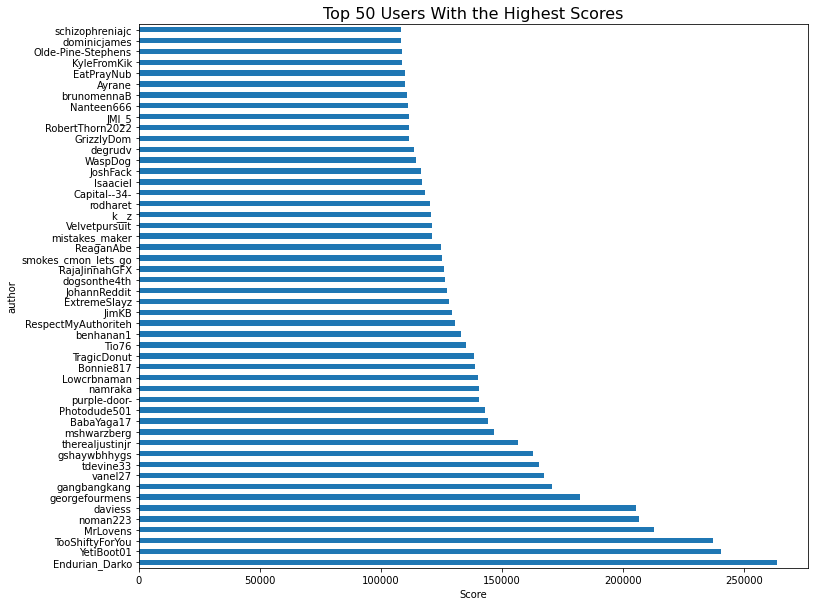

In [31]:
#top 50 authors by score
top50author_score = data.groupby('author')['score'].sum().sort_values(ascending=False).sort_values(ascending=False)[1:51]
top50author_score.plot(kind='barh', figsize=(12,10))
plt.title('Top 50 Users With the Highest Scores', fontsize=16)
plt.xlabel('Score')

In [32]:
# number of authors shared by the two top author lists based on number of comments and score
len([author for author in top50author_comments.index if author in top50author_score.index])

24

As seen above, the top 50 author lists by score and number of comments have 24 authors in common, which is much higher than the 7 authors shared between the top authors by number of comments and number of posts. This suggests that the score of a post is much more correlated to the number of comments of the post than the number of posts made by the same host. Next let's look at score distribution of posts.

Text(0.5, 0, 'Score')

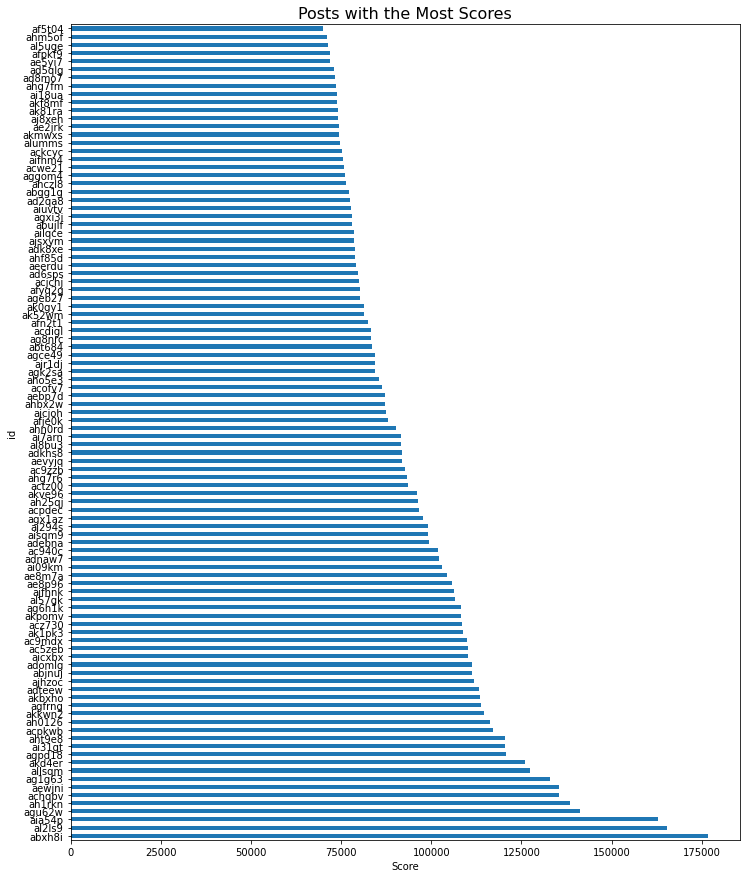

In [33]:
#top 100 posts by score
top100post_score = data.groupby('id')['score'].sum().sort_values(ascending=False).sort_values(ascending=False)[0:100]
# number of posts under each subreddit
top100post_score.plot(kind='barh', figsize=(12,15))
plt.title('Posts with the Most Scores', fontsize=16)
plt.xlabel('Score')

In [34]:
# author of the post with the highest score
top100post_score.index[0], data.loc[data['id']==top100post_score.index[0]]['author']

('abxh8i', 12390    [deleted]
 Name: author, dtype: object)

The author of the post with the highest score is deleted, let's look at the author of the post with the second-highest score:

In [35]:
top100post_score.index[1], data.loc[data['id']==top100post_score.index[1]]['author']

('al2ls9', 209383    tdevine33
 Name: author, dtype: object)

In [36]:
#number of posts by this author
data.loc[data['author']=='tdevine33'].groupby('id')['author'].count()

id
al2ls9    1
Name: author, dtype: int64

Similar to the author of the post with the most comments, the author of the post with the second highest score has only posted once, which contributes to our idea of the virality of a post. 

To test this idea and see how it is linked to subreddit classes, let's loosely define the threshold of a viral post to have a score of higher than 50:

In [37]:
# defining a viral post threshold of > 50
data['viral'] = data['score']>50

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


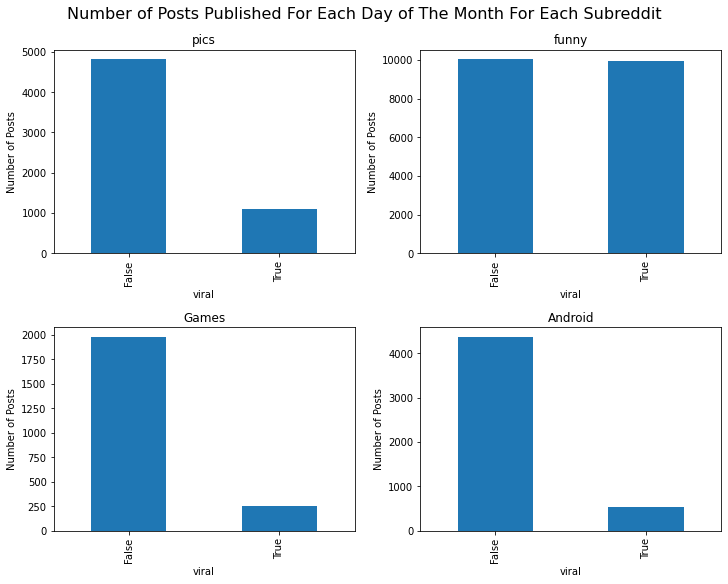

In [38]:
# plotting viral vs non-viral posts for each subreddit
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
i=0
for row in ax:
    for col in row:
        data.loc[data['subreddit']==my_subreddits[i]].groupby('viral')['subreddit'].count().plot(kind='bar', figsize=(10,8), ax=col)
        col.set_title(my_subreddits[i])
        col.set_ylabel('Number of Posts')
        i+=1

fig.suptitle('Number of Posts Published For Each Day of The Month For Each Subreddit', fontsize=16)
plt.show()

From the figures above, we can see that the subreddit 'funny' has an almost equal amount of 'viral' posts than 'non-viral' posts, which cannot be said for the other three subreddits. This suggests that the column 'viral' has a limited relationship with the subreddit classes. Let's check the mutual information of the 'viral' column with the subreddit classes.



In [39]:
miScore_viral = (['viral']+[metrics.normalized_mutual_info_score(data['subreddit'], data['viral'])])
miScore_viral

['viral', 0.0845469909707989]

The mutual information also suggests that the 'viral' column is fairly independent of the subreddit classes.

###2.6 Exploring Post Titles



In [40]:
miScore_titles = (['title']+[metrics.normalized_mutual_info_score(data['subreddit'], data['title'])])
miScore_titles

['title', 0.18801030089532358]

Since the post titles are in the form of unstructured text, we will need to perform NLP of the titles in order to gain insight of its feature importance. First, we will tokenize and filter for stop words:

In [0]:
def DataProcessor (title_list):
       
    stop_words = stopwords.words("english") + ['get', 'got', 'like', 'one', 'today', 'think', 'found', 'first', 'took', 'think', 'know', 'need', 'really', 'need', 'make', 'made', 'looks', 'look', 'way', 'ever', 'go', 'still', 'looking', 'never', 'would', 'going']
    filtered_list = []
    ps = PorterStemmer()

    for title in title_list:

        #remove punctuations
        tokenizer = RegexpTokenizer(r'\w+')
        title = tokenizer.tokenize(title)
        title = ' '.join(title) 

        #remove single-character words, numbers, and stopwords; convert to lower()
        word_tokens = word_tokenize(title)
        filtered_words = [w.lower() for w in word_tokens if len(w) >1 and not w.isdigit() and w.lower() not in stop_words]
        title = ' '.join(filtered_words)  
        
        filtered_list.append(title)

      
    return filtered_list

In [0]:
titles = data['title'].tolist()
filtered_titles = DataProcessor(titles)

Note that the stopwords have been modified to include words specific to the dataset that do not contribute to the analysis. 

Next, we will look at top 50 unigrams (single words) with the most frequency in titles. 

In [0]:
# getting top k unigrams from titles
def top_k_unigrams(titlelist, k):
    
    word_list = [word_tokenize(title) for title in titlelist]
    flat_list = [item for sublist in word_list for item in sublist]
    c = Counter([word for word in flat_list])
    top_k = c.most_common(k)
    dict_word_count = { j[0]: j[1:] for j in top_k }
    words=list(dict_word_count.keys())
    counts=[]
    counts.append([top_k[i][1] for i in range(k)])
    counts = sum(counts, [])
    
    return words, counts

In [0]:
top_unigrams, top_unigram_count = top_k_unigrams(filtered_titles, 50)

Text(0.5, 0, 'Word Count')

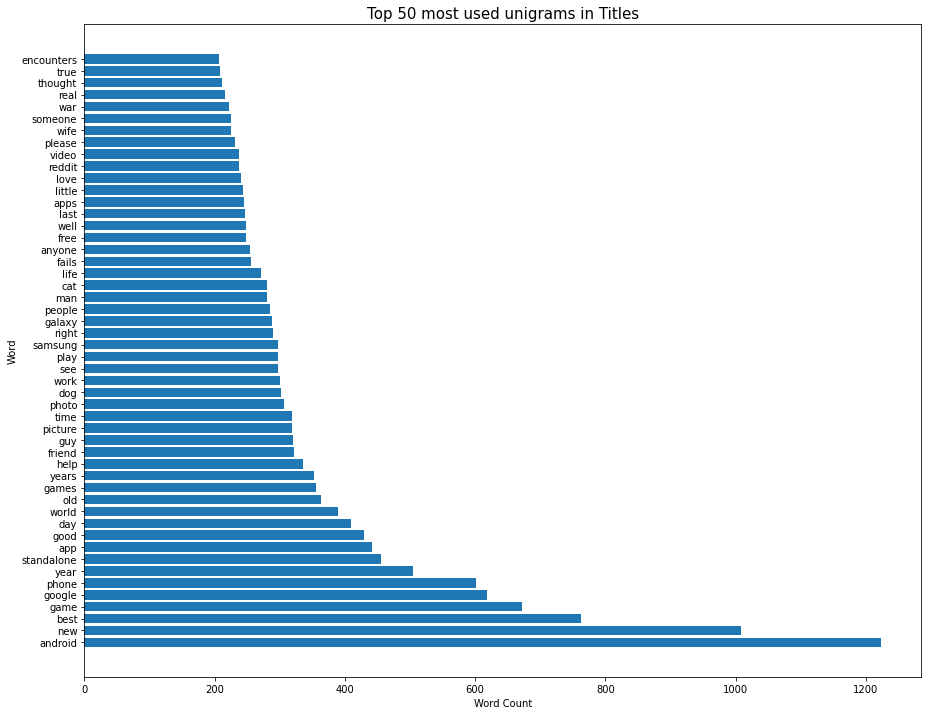

In [45]:
# plotting top unigrams vs counts
plt.figure(figsize=(15,12))
plt.barh(top_unigrams, top_unigram_count, align='center')
plt.title('Top 50 most used unigrams in Titles', fontsize=15)
plt.ylabel('Word')
plt.xlabel('Word Count')

The top word frequencies range from over 1200 ('android') to around 250 ('man'). Next, we will create a dataframe containing information whether a title contains the words (1) or not (0), for every post.

In [0]:
# creating df with top unigrams and post titles (1 for unigram in title, 0 otherwise)
df_rows = []
ps = PorterStemmer()

for title in titles:
  
  df_rows.append([1 if ps.stem(unigram) in ps.stem(title) else 0 for unigram in top_unigrams])

df_unigrams = pd.DataFrame(df_rows, columns=top_unigrams)

In [47]:
# adding encoded subreddit classes to unigram df using label encoder
le = preprocessing.LabelEncoder()
le.fit(data['subreddit'])

df_unigrams['subreddit_encoded'] = le.transform(data['subreddit'])
data['subreddit_encoded'] = le.transform(data['subreddit'])
df_unigrams.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,android,new,best,game,google,phone,year,standalone,app,good,day,world,old,games,years,help,friend,guy,picture,time,photo,dog,work,see,play,samsung,right,galaxy,people,man,cat,life,fails,anyone,free,well,last,apps,little,love,reddit,video,please,wife,someone,war,real,thought,true,encounters,subreddit_encoded
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


Using the above dataframe, we will look at the correlations between the top unigrams and the encoded subreddit classes. 

Text(0.5, 1.0, 'Diagonal Correlation Plot for Top 50 Unigrams in Titles')

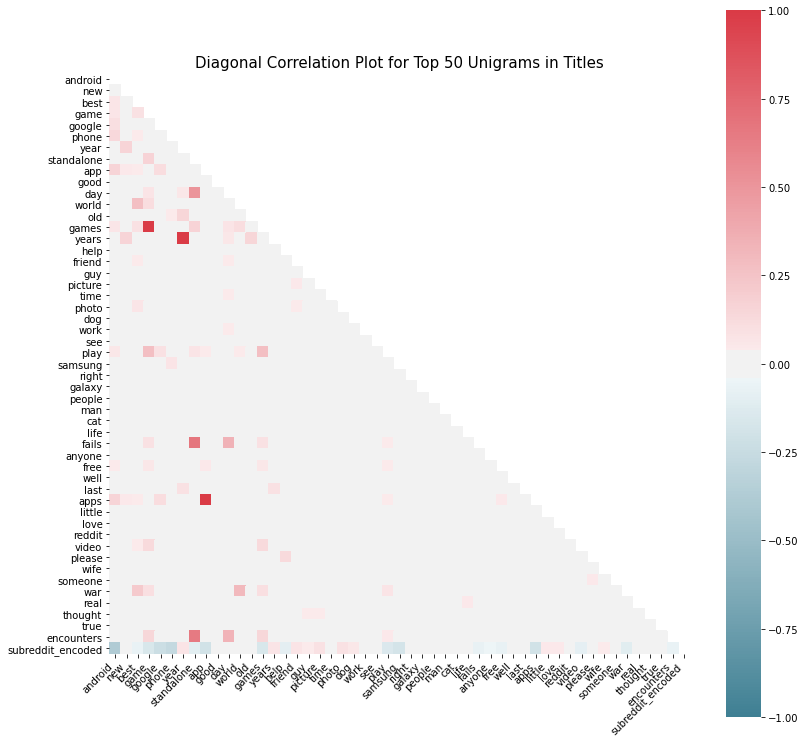

In [48]:
#plotting diagonal correlation matrix for unigrams and subreddit classes
corr_unigrams = df_unigrams.corr()

plt.figure(figsize=(13, 13))
mask = np.triu(np.ones_like(corr_unigrams, dtype=np.bool))

ax = sns.heatmap(
    corr_unigrams, 
    mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.title('Diagonal Correlation Plot for Top 50 Unigrams in Titles', fontsize=15)

From the bottome section of the plot above we can see that the majority of top unigrams have either positive or negative correlations with the subreddit classes. Next, let look how these words perform in terms of mutual information with the subreddit classes.

In [0]:
# get Top K mutual information terms for unigrams
def getMI(topk, df, label_column='subreddit_encoded'):
    miScore = []
    for word in topk:
        miScore.append([word]+[metrics.normalized_mutual_info_score(df[label_column], df[word])])
    miScoredf = pd.DataFrame(miScore, index=topk).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

Text(0.5, 0, 'Normalized Mutual Information Score')

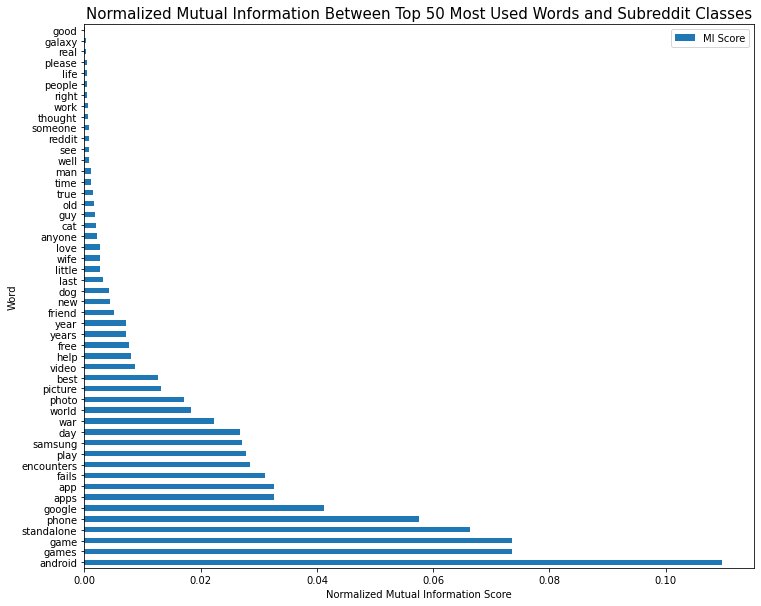

In [50]:
# getting and plotting MI for top unigrams
miScore_unigrams = getMI(top_unigrams, df_unigrams)
miScore_unigrams.plot(kind='barh', figsize=(12, 10))
plt.title('Normalized Mutual Information Between Top 50 Most Used Words and Subreddit Classes', fontsize=15)
plt.ylabel('Word')
plt.xlabel('Normalized Mutual Information Score')

Almost all of the top words bear some mutual information with the subreddit classes. Together with the results of the correlation plot, it can be said that these frequent words are quite informative when it comes to understanding the subreddit classes.

There are two columns left for EDA which are 'selftext' and 'url'. Both of which are 'optional' meaning that a post may or may not contain information in these columns. We will first look at the 'selftext' column.

### 2.7 Exploring Self Texts

The 'selftext' column contains the body text of a post. From an intial look at the original dataframe, this column seems to be quite empty. Let's first see what information is contained in this column.

In [51]:
common_values = Counter(data['selftext'].tolist()).most_common(5)
common_values

[('', 24086),
 ('[deleted]', 5427),
 ('[removed]', 3172),
 ('**Credits to the team at /r/PickAnAndroidForMe for compiling this information:**\n\n* Home - https://www.reddit.com/r/PickAnAndroidForMe/wiki/index\n\n* Smartphones 101 - https://www.reddit.com/r/PickAnAndroidForMe/wiki/smartphones101\n\n* Top Phones - https://www.reddit.com/r/PickAnAndroidForMe/wiki/phones\n\n\n***        \nNote 1. Join us at /r/MoronicMondayAndroid, a sub serving as a repository for our retired weekly threads. Just pick any thread and Ctrl-F your way to wisdom! \n\nNote 2. Join our Discord, IRC, and Telegram chat-rooms! [Please see our wiki for instructions.](https://www.reddit.com/r/Android/wiki/index#wiki_.2Fr.2Fandroid_chat_rooms)\n',
  5),
 ('Note 1. [Check out our apps wiki](https://www.reddit.com/r/Android/wiki/index#wiki_apps) for previous threads and apps curated by the reddit Android community!  \n\n***[NEW: Download the official /r/Android App Store based on our wiki!](https://github.com/d4rken/re

There are 3 values indicating that the body text of a post is non-existent. To see what proportion theses account for out of all posts:

In [0]:
empty_index = data[data['selftext'] == ''].index
deleted_index = data[data['selftext'] == '[deleted]'].index 
removed_index = data[data['selftext'] == '[removed]'].index

# indices that do not contain texts
no_text_index = empty_index.union(deleted_index).union(removed_index)

data_index = data.index

# indices that contain texts
text_index = data_index.difference(no_text_index)

Text(0, 0.5, 'Count')

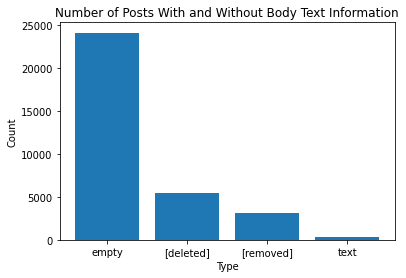

In [53]:
# plotting empty indices against indices that contain texts
indices = ['empty', '[deleted]', '[removed]', 'text']
count = [len(empty_index), len(deleted_index), len(removed_index), len(text_index)]
plt.bar(indices, count)
plt.title('Number of Posts With and Without Body Text Information')
plt.xlabel('Type')
plt.ylabel('Count')

From the above plot, seeing that the great majority of posts do not contain information for the column of 'selftext', therefore this column should not be included in the analysis. 

Next, let's look at the second optional column 'url'.

###2.8 Exploring URL

The column 'url' contains the url the post is linked with. Let's begin by checking for empty values like we did for selftext.

In [54]:
common_values = Counter(data['url'].tolist()).most_common(5)
common_values

[('https://www.vidmateapkdownload.co', 9),
 ('https://www.nokia.com/phones/en_int/opensource', 4),
 ('https://www.dualshockers.com/cvaa-2019-games-to-be-made-accessible-for-disabilities/',
  4),
 ('https://www.xda-developers.com/android-q-dark-theme-desktop-mode-permission-revamp/',
  4),
 ('https://www.theverge.com/circuitbreaker/2019/1/17/18186463/google-pixel-3-lite-video-review-camera',
  4)]

As seen above, there are no empty values in the column 'url'. Also, the url of posts are quite unique, with the most common url occuring 9 times in all posts. In addition to the fact that the url information cannot directly be used for classification, we will need to perform additional processing of the url data to gain further insight. 

Let's first look at the mutual information of the url with the subreddit classes.

In [55]:
miScore_url = (['url']+[metrics.normalized_mutual_info_score(data['subreddit'], data['url'])])
miScore_url

['url', 0.18752269266753102]

The url is quite informative from the perspective of mutual information. 

To analyze further:
 
From first look, it seems that the url can generally be divided into two types: jpg/png (picture), and website (reddit or other sites). Since one of our subreddit is 'pics', it may be meaningful to analyze this way. As such, let's check which post url can be categorized as pictures, and which are websites. 

In [56]:
url_type = []

# classifying picture url as 1 and otherwise 0
for url in data['url']:

  if url[-3:] =='jpg' or url[-3:] == 'png':
    url_type.append('1')
  else:
    url_type.append('0')

data['url_type'] = url_type

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


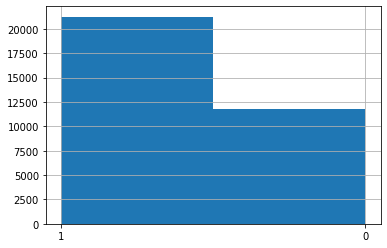

In [57]:
data.url_type.hist(bins=2, align='mid')

We can see that there is much more urls linking to pictures than websites. Checking mutual information of the url_type column:

In [58]:
miScore_url_type = (['url_type']+[metrics.normalized_mutual_info_score(data['subreddit'], data['url_type'])])
miScore_url_type

['url_type', 0.3413685126546333]

The type of url is better than the original url in terms of mutual information with the target column (0.34 vs 0.19).

We are also interested in the most frequent keywords/websites that are linked by these urls. Therefore, let's look at frequent keywords in the urls:

In [0]:
#getting top keywords from urls
url_list = data['url'].tolist()
url_keywords = []
stop_words = ['https:', 'imgur.com', '?utm_source=ifttthttp:', 'youtu.be', 'index.php', 'http:', '?utm_source=ifttthttps:', 'en', 'amp']

for url in url_list:
  keywords = url.split('/')
  filtered_keywords = filtered_words = [w for w in keywords if len(w) >1 and not w.isdigit() and w not in stop_words]
  url_keywords.append(filtered_keywords)

url_keywords = [item for sublist in url_keywords for item in sublist]
url_keywords = Counter(url_keywords).most_common(50)

In [0]:
# creating df with top url keywords and post titles (1 for keywords in url, 0 otherwise)
df_rows = []
dict_word_count = { j[0]: j[1:] for j in url_keywords}
top_url_keywords=list(dict_word_count.keys())
url_keywords_counts=[]
url_keywords_counts.append([url_keywords[i][1] for i in range(len(url_keywords))])
url_keywords_counts = sum(url_keywords_counts, [])

for url in url_list:

  url = url.split('/')
  df_rows.append([1 if keyword in url else 0 for keyword in top_url_keywords])

df_url_keywords = pd.DataFrame(df_rows, columns=top_url_keywords)
df_url_keywords['subreddit_encoded'] = le.transform(data['subreddit'])

Text(0.5, 0, 'Keywords Count')

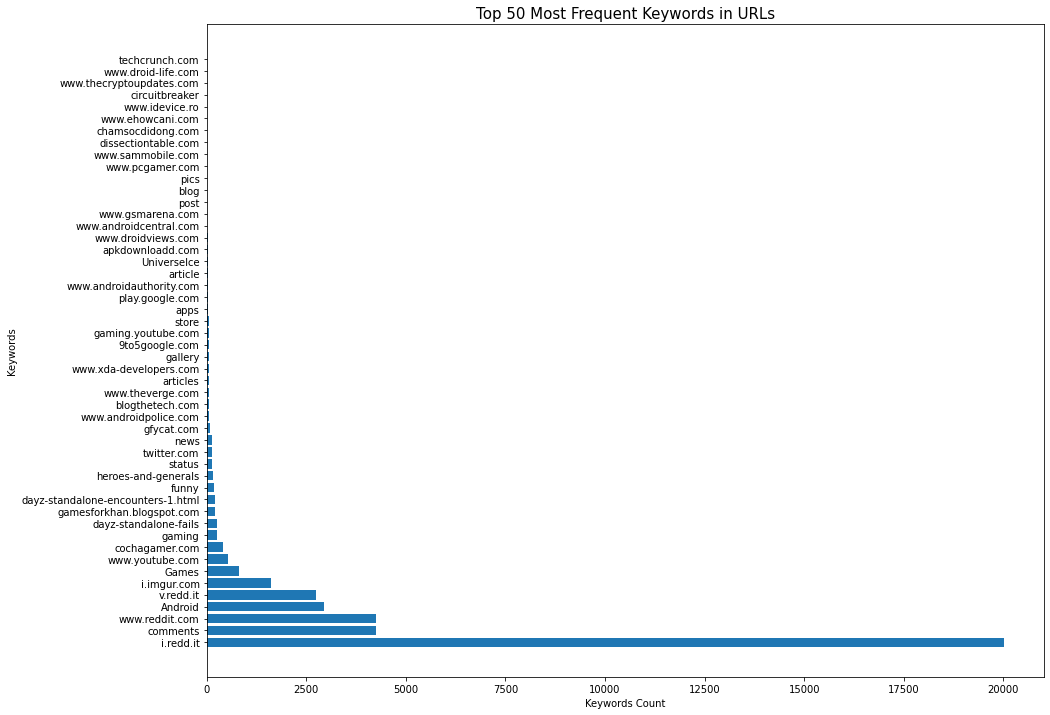

In [61]:
# plotting top unigrams vs counts
plt.figure(figsize=(15,12))
plt.barh(top_url_keywords, url_keywords_counts, align='center')
plt.title('Top 50 Most Frequent Keywords in URLs', fontsize=15)
plt.ylabel('Keywords')
plt.xlabel('Keywords Count')

The majority of keywords that have high counts have to do with reddit.com itself. Note that i.redd.it indicates an image and v.redd.it indicates a video. This means that we can use this information to replace our previous analysis of url_type.

Next, looking at the mutual information of url keywords:

Text(0.5, 0, 'Normalized Mutual Information Score')

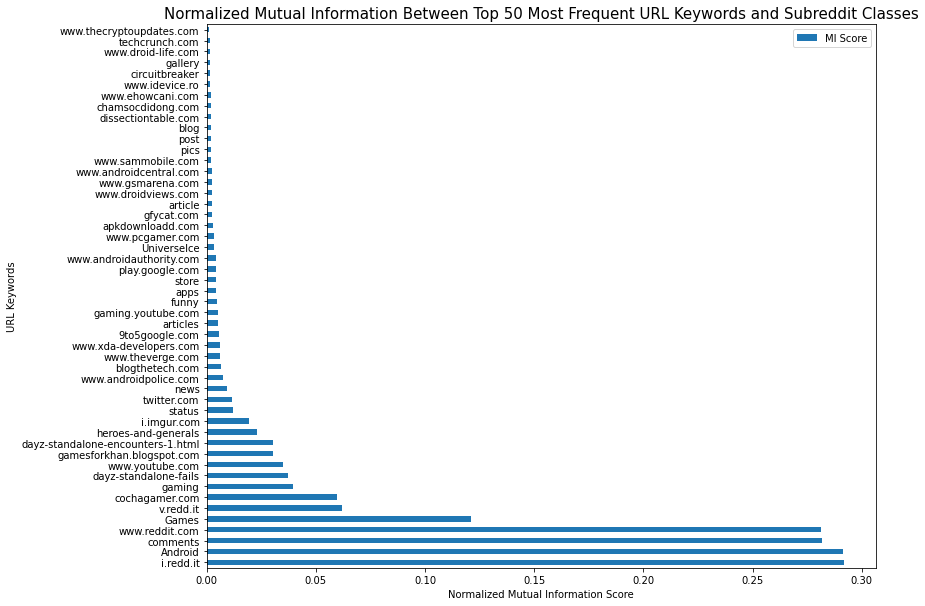

In [62]:
# getting and plotting MI for top url keywords
miScore_url_keywords = getMI(top_url_keywords, df_url_keywords)
miScore_url_keywords.plot(kind='barh', figsize=(12, 10))
plt.title('Normalized Mutual Information Between Top 50 Most Frequent URL Keywords and Subreddit Classes', fontsize=15)
plt.ylabel('URL Keywords')
plt.xlabel('Normalized Mutual Information Score')

The ranking of mutual information are similar to the frequency distribution of the keywords, and this suggest that these top url keywords are quite correlated with the subreddit classes. 

### 2.9 Exploring ID

The column 'id' contains information of the unique identifying code of a post. By nature, all the values in the columns are unique without duplicates. 

Checking mutual information:

In [63]:
miScore_id = (['id']+[metrics.normalized_mutual_info_score(data['subreddit'], data['id'])])
miScore_id

['id', 0.18748488172645905]

There exists some dependency between the 'id' column and the target column in terms of mutual information. 

### 3.0 Summarizing of Feature Importances

So far we have explored the importance of every column with respect to the subreddit classes, with further processing of some columns (such as url) in hope of improving feature importance.

In [64]:
data.head(3)

,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,day_of_week,day_night,hour,minute,viral,subreddit_encoded,url_type
1,abcuz2,mikebeingfrank,1546300881,pics,"In 1964, an average wage worker had to clock 8...",4,5,,https://i.redd.it/j6rqqthwcp721.jpg,2,1,12,01,False,3,1
5,abcv7e,RyanGwood12,1546300923,pics,Here’s a reminder to grab one of these for a b...,12,0,,https://i.redd.it/063lwxm0dp721.jpg,2,1,12,02,False,3,1
13,abcvty,popedotninja,1546301036,pics,My best photo of 2018!,5,5,,https://i.redd.it/nkcs1p8adp721.jpg,2,1,12,03,False,3,1


Text(0, 0.5, 'Column')

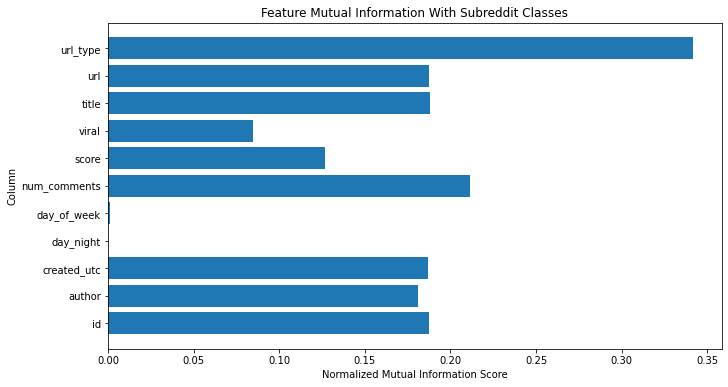

In [65]:
#combining mi values of each column
mi_columns = [miScore_id[0], miScore_author[0], miScore_utc[0], miScore_daynight[0], miScore_day_of_week[0], miScore_comments[0], miScore_score[0], miScore_viral[0], miScore_titles[0], miScore_url[0], miScore_url_type[0]]
mi_values = [miScore_id[1], miScore_author[1], miScore_utc[1], miScore_daynight[1], miScore_day_of_week[1], miScore_comments[1], miScore_score[1], miScore_viral[1], miScore_titles[1], miScore_url[1], miScore_url_type[1]]

#plotting and comparing mi scores of each column
plt.figure(figsize=(11,6))
plt.barh(mi_columns, mi_values)
plt.title('Feature Mutual Information With Subreddit Classes')
plt.xlabel('Normalized Mutual Information Score')
plt.ylabel('Column')

Base on the above plot, we will choose columns with higher mutual information to the subreddit classes, while dropping columns that are deemed relatively unimportant to classification of subreddits or redundant with other columns. Although the column 'id' bears some mutual information with regards to the subreddit classes, we will drop this column since it is non-numeric and is not helpful to encode due to its large amount of unique values. Also, the column 'utc_timestamp' will be replaced by other time values (converted from utc) such as hour and minute. This is because the large numeric value of the original timestamp column will introduce a large bias errors into our classification models later on.

Note that author information will not be included in the feature set since the top authors only account for a small portion of all tweets published (e.g. the top author published 400 posts compared to the total of over 33,000 posts in total).

Also note that we will replace both the 'title' and 'url' with their corresponding top 50 keywords.

In [0]:
#dropping unecessary/duplicate columns
data_clean = data.drop(['id', 'url', 'url_type', 'title', 'viral', 'selftext', 'subreddit_encoded', 'subreddit', 'created_utc', 'author'], axis=1).reset_index()
#adding unigram df to data_clean
data_clean = pd.concat([data_clean, df_unigrams], axis=1).drop(['index', 'subreddit_encoded'], axis=1)
data_clean = pd.concat([data_clean, df_url_keywords], axis=1)

In [0]:
# reorganizing target column
mid = data_clean['subreddit_encoded']
data_clean.drop(labels=['subreddit_encoded'], axis=1, inplace = True)
data_clean.insert(6, 'subreddit_encoded', mid)

In [68]:
data_clean.head(3)

,num_comments,score,day_of_week,day_night,hour,minute,subreddit_encoded,android,new,best,game,google,phone,year,standalone,app,good,day,world,old,games,years,help,friend,guy,picture,time,photo,dog,work,see,play,samsung,right,galaxy,people,man,cat,life,fails,...,dayz-standalone-fails,gamesforkhan.blogspot.com,dayz-standalone-encounters-1.html,funny,heroes-and-generals,status,twitter.com,news,gfycat.com,www.androidpolice.com,blogthetech.com,www.theverge.com,articles,www.xda-developers.com,gallery,9to5google.com,gaming.youtube.com,store,apps,play.google.com,www.androidauthority.com,article,UniverseIce,apkdownloadd.com,www.droidviews.com,www.androidcentral.com,www.gsmarena.com,post,blog,pics,www.pcgamer.com,www.sammobile.com,dissectiontable.com,chamsocdidong.com,www.ehowcani.com,www.idevice.ro,circuitbreaker,www.thecryptoupdates.com,www.droid-life.com,techcrunch.com
0,4,5,2,1,12,01,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,0,2,1,12,02,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,5,2,1,12,03,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## b) Removal of Punctuations in Titles

In the text processing of titles, it is observed that many contain punctuations and symbols. These have been removed as shown in section 2.6 above. This is because although punctuation can be informative, they can introduce a lot of noise to our data set during classification. Since we are only considering the top k words, including punctuations amongst thses words can take the space of valuable words that may be more informative. Also, punctuations play a much bigger role in part 4 of sentiment analysis.

## c) Imbalanced Dataset and Outliers: Please refer to section 2.1 above

# Part 3: Classification

## 3.1 Model Comparisons

Looking at the full dataset:

In [69]:
data_clean.head()

,num_comments,score,day_of_week,day_night,hour,minute,subreddit_encoded,android,new,best,game,google,phone,year,standalone,app,good,day,world,old,games,years,help,friend,guy,picture,time,photo,dog,work,see,play,samsung,right,galaxy,people,man,cat,life,fails,...,dayz-standalone-fails,gamesforkhan.blogspot.com,dayz-standalone-encounters-1.html,funny,heroes-and-generals,status,twitter.com,news,gfycat.com,www.androidpolice.com,blogthetech.com,www.theverge.com,articles,www.xda-developers.com,gallery,9to5google.com,gaming.youtube.com,store,apps,play.google.com,www.androidauthority.com,article,UniverseIce,apkdownloadd.com,www.droidviews.com,www.androidcentral.com,www.gsmarena.com,post,blog,pics,www.pcgamer.com,www.sammobile.com,dissectiontable.com,chamsocdidong.com,www.ehowcani.com,www.idevice.ro,circuitbreaker,www.thecryptoupdates.com,www.droid-life.com,techcrunch.com
0,4,5,2,1,12,01,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12,0,2,1,12,02,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,5,2,1,12,03,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,46,2,1,12,04,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,69,2,1,12,05,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Splitting feature set and target set:

In [0]:
# full feature set
X = data_clean.drop(columns=['subreddit_encoded'])

# target (subreddits)
target = data_clean.loc[:, 'subreddit_encoded']

In [0]:
#scaling feature set
scaler = preprocessing.StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

A few notes on the evaluation methods above: 

 - Splitting test/train: train/test proportions are set to 70% and 30% to ensure sufficient training instances while also maintaining a signficant amount of testing data. Also, data splitting is performed before data scaling (i.e. scaling is performed separately for train and test sets) to prevent overfitting.

 - Scaling: since columns such as 'num_comments' and 'score' vary greatly in terms of numeric value compared to the rest of the data, it is necessary to normalize the feature set before classification.

Next, let's explore three different classifiers (logistic regression, gaussian naive bayes, and svm) on the full feature set. 

To measure the performance of each model, we will use the following metrics:

- F1 Score (test and train)
- Recall (test)
- Precision (test)
- Confusion Matrix (test)

Since our dataset is very imbalanced, we should avoid using accuracy as a metric for our models, since high accuracy for an imbalanced dataset does not suggest good performance (i.e. predictions are skewed towards the majority classes). We will explore the F1 score, recall, and precision of the dataset, amongst which recalls is the best suited for our imbalanced multiclass dataset. This is because recall provides information on the coverage of the positive classes, thus is capable of measuring the coverage of the minority classes.

We will also utilize the confusion matrix as a metric. The confusion matrix will allow us to visualize the prediciton performance for each class, and see which model perform particularily well or bad in predicting certain classes. 

Note that to better account for class imbalance, we will use 'average' equal to 'macro' instead of 'weighted' for the metrics, to give all classes equal weight when calculating the average scores. Also, we will use one-vs-rest for our binary classifiers (logistic regression and svm). We use one-vs-rest instead of multinomial because ovr uses the binary classification algorithm and tends to be less biased towards certain classes.

In [0]:
def Classifiers(X_train, X_test, y_trian, y_test):

  #defining classifiers
  #both logistic regression and svm use ovr multiclass
  logreg = LogisticRegression(multi_class='ovr', max_iter=1000)
  gnb = GaussianNB()
  svm = SVC(decision_function_shape = 'ovr', random_state=0)

  # calculating training and testing accuracies, and F1 score for each classifier
  # logistic regression
  logreg_y_pred_train = logreg.fit(X_train, y_train).predict(X_train)
  logreg_y_pred_test = logreg.fit(X_train, y_train).predict(X_test)

  logreg_y_train_F1 = metrics.f1_score(y_train, logreg_y_pred_train, average='macro')
  logreg_y_test_F1 = metrics.f1_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_recall = metrics.recall_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_precision = metrics.precision_score(y_test, logreg_y_pred_test, average='macro')

  # gaussian nb
  gnb_y_pred_train = gnb.fit(X_train, y_train).predict(X_train)
  gnb_y_pred_test = gnb.fit(X_train, y_train).predict(X_test)

  gnb_y_train_F1 = metrics.f1_score(y_train, gnb_y_pred_train, average='macro')
  gnb_y_test_F1 = metrics.f1_score(y_test, gnb_y_pred_test, average='macro')
  gnb_y_test_recall = metrics.recall_score(y_test, gnb_y_pred_test, average='macro')
  gnb_y_test_precision = metrics.precision_score(y_test, gnb_y_pred_test, average='macro')

  # svm
  svm_y_pred_train = svm.fit(X_train, y_train).predict(X_train)
  svm_y_pred_test = svm.fit(X_train, y_train).predict(X_test)

  svm_y_train_F1 = metrics.f1_score(y_train, svm_y_pred_train, average='macro')
  svm_y_test_F1 = metrics.f1_score(y_test, svm_y_pred_test, average='macro')
  svm_y_test_recall = metrics.recall_score(y_test, svm_y_pred_test, average='macro')
  svm_y_test_precision = metrics.precision_score(y_test, svm_y_pred_test, average='macro')


  #combining metrics into a single dataframe
  results = {'LogReg': [logreg_y_train_F1, logreg_y_test_F1, logreg_y_test_recall, logreg_y_test_precision], 
             'GNB': [gnb_y_train_F1, gnb_y_test_F1, gnb_y_test_recall, gnb_y_test_precision], 
             'SVM': [svm_y_train_F1, svm_y_test_F1, svm_y_test_recall, svm_y_test_precision]}

  classifier_df = pd.DataFrame(results, index =['Train F1 Score', 'Test F1 Score', 'Test Recall', 'Test Precision']) 

  #confusion matrices for the three classifiers
  cm_logreg = confusion_matrix(y_test, logreg_y_pred_test, labels=data_clean['subreddit_encoded'].unique().tolist())
  cm_gnb = confusion_matrix(y_test, gnb_y_pred_test, labels=data_clean['subreddit_encoded'].unique().tolist())
  cm_svm = confusion_matrix(y_test, svm_y_pred_test, labels=data_clean['subreddit_encoded'].unique().tolist())

  return classifier_df, cm_logreg, cm_gnb, cm_svm

In [0]:
classifier_df, cm_logreg, cm_gnb, cm_svm = Classifiers(X_train_scaled, X_test_scaled, y_train, y_test)

In [74]:
classifier_df

,LogReg,GNB,SVM
Train F1 Score,0.723918,0.577914,0.740453
Test F1 Score,0.716814,0.581386,0.699966
Test Recall,0.708512,0.662500,0.688772
Test Precision,0.808886,0.739043,0.811701


As seen in the table above, we can see that both logistic regression and SVM perform quite well on the full dataset, with gaussian naive bayes performing poorly. Worth noting is that the train and test F1 scores are very similar for each classifier, which suggests that our models are well-generalised. The recall score for all three models are less than there precision counterparts, which is expected due to class imbalance. Based on the recall scores, it can reasonably said that logistic regression is the best performer out of the three models.

Next, lets look at the confusion matrix performance for each model:

In [0]:
#this function prints and plots the confusion matrix, with normalization
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.14604236 0.84671126 0.00278707 0.00445931]
 [0.02150893 0.97137657 0.00198544 0.00512905]
 [0.00565771 0.05304102 0.90594059 0.03536068]
 [0.01374046 0.12061069 0.05496183 0.81068702]]


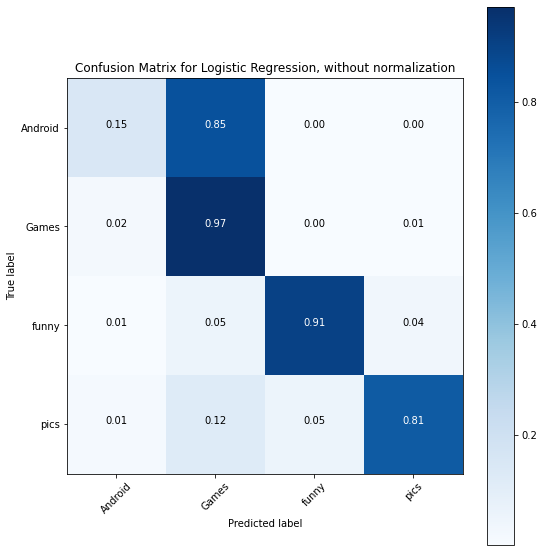

In [76]:
# plot for logistic regression confusion matrix (normalized)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_logreg, classes=['Android', 'Games', 'funny', 'pics'],
                      title='Confusion Matrix for Logistic Regression, without normalization')

Normalized confusion matrix
[[9.84392419e-01 1.50501672e-02 0.00000000e+00 5.57413601e-04]
 [8.27928524e-01 1.71575116e-01 0.00000000e+00 4.96360026e-04]
 [1.04667610e-01 3.18246110e-02 7.96322489e-01 6.71852900e-02]
 [2.06106870e-01 8.39694656e-02 1.22137405e-02 6.97709924e-01]]


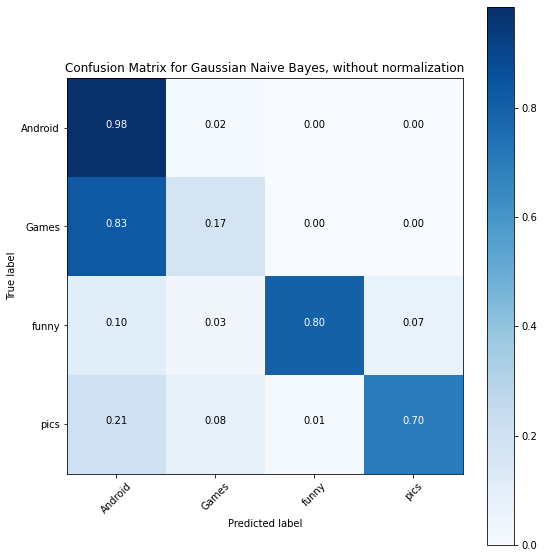

In [77]:
# plot for GNB confusion matrix (normalized)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_gnb, classes=['Android', 'Games', 'funny', 'pics'],
                      title='Confusion Matrix for Gaussian Naive Bayes, without normalization')

Normalized confusion matrix
[[0.12541806 0.86454849 0.0083612  0.00167224]
 [0.0173726  0.97600927 0.00215089 0.00446724]
 [0.00424328 0.06364922 0.9009901  0.0311174 ]
 [0.00305344 0.16335878 0.08091603 0.75267176]]


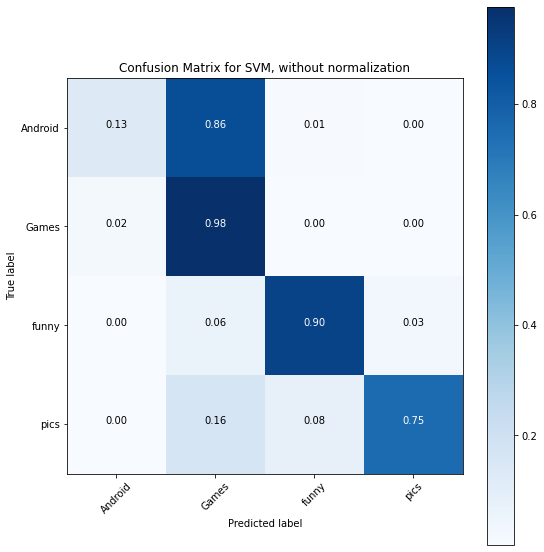

In [78]:
# plot for SVM confusion matrix (normalized)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_svm, classes=['Android', 'Games', 'funny', 'pics'],
                      title='Confusion Matrix for SVM, without normalization')

As seen in the confusion matrix plots above, all three classifiers struggle in predicting between the classes of 'Games' and 'Android'. Gaussian naive bayes performs worse in predicting every class than logistic regression and SVM, which explains its poor metric performances (F1, precision, and recall) in the previous section. 

Looking at SVM and logistic regression, the two perform similarly with the exception of predicting the class 'pics', in which logistic regression performs slightly better than SVM (0.81 vs 0.75). 

Since logisitic regression performs better than SVM (though marginally) in terms of recall and the confusion matrix, we will carry forward with Logistic Regression as our classifier.

## 3.2 Feature Set Comparisons

In addition to model comparisons, we are also interested in which feature subset perform better for our model of choice. Therefore, we will split the full feature set into three subsets: 

  - 'post_tags' or X1: these contain original and transformed information of the reddit posts, including number of comments, score, and time (transformed into hour, minute, day of week, and AM/PM).

  - 'title_keywords' or X2: these include the 50 top keywords found in post titles.

  - 'url_keywords' or X3: these include the 50 top keywords found in urls.

Note that data scaling is only necessary for X1 (post_tags) since the keyword feature sets use binary encoding (0/1) which does not require scaling. 

In [0]:
def Feature_Comparisons (data):

  # features including num_comments, score, and time (hour, minute, day of week, and AM/PM)
  X1 = data.loc[:, 'num_comments':'minute']
  # features including top words in titles
  X2 = data.loc[:, 'android':'encounters']
  # features including top words in urls
  X3 = data.loc[:, 'i.redd.it':'techcrunch.com']
  # target (subreddits)
  target = data.loc[:, 'subreddit_encoded']

  #splitting train/test
  X1_train, X1_test, y_train, y_test = train_test_split(X1, target, test_size=0.3, random_state=0)
  X2_train, X2_test, y_train, y_test = train_test_split(X2, target, test_size=0.3, random_state=0)
  X3_train, X3_test, y_train, y_test = train_test_split(X3, target, test_size=0.3, random_state=0)

  #scaling X1
  scaler = preprocessing.StandardScaler()

  X1_train, X1_test, y_train, y_test = train_test_split(X1, target, test_size=0.3, random_state=0)
  X1_train_scaled = scaler.fit_transform(X1_train)
  X1_test_scaled = scaler.transform(X1_test)

  training_sets = [X1_train_scaled, X2_train, X3_train]
  test_sets = [X1_test_scaled, X2_test, X3_test]

  #svm model training on each feature set
  logreg = LogisticRegression(multi_class='ovr', max_iter=1000)

  logreg_y_pred_train = []
  logreg_y_pred_test = []
  logreg_y_train_F1 = []
  logreg_y_test_F1 = []
  logreg_y_test_recall = []
  logreg_y_test_precision = []
  
  for i in range(3):

    logreg_y_pred_train.append(logreg.fit(training_sets[i], y_train).predict(training_sets[i]))
    logreg_y_pred_test.append(logreg.fit(training_sets[i], y_train).predict(test_sets[i]))

    logreg_y_train_F1.append(metrics.f1_score(y_train, logreg_y_pred_train[i], average='macro'))
    logreg_y_test_F1.append(metrics.f1_score(y_test, logreg_y_pred_test[i], average='macro'))
    logreg_y_test_recall.append(metrics.recall_score(y_test, logreg_y_pred_test[i], average='macro'))
    logreg_y_test_precision.append(metrics.precision_score(y_test, logreg_y_pred_test[i], average='macro'))
  
  df_features = pd.DataFrame(list(zip(logreg_y_train_F1, logreg_y_test_F1, logreg_y_test_recall, logreg_y_test_precision)), 
                    columns = ['Train F1 Score', 'Test F1 Score', 'Test Recall', 'Test Precision'],
                    index = ['post_tags', 'title_keywords', 'url_keywords']) 
  
  return df_features

In [80]:
Feature_Comparisons(data_clean)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train F1 Score,Test F1 Score,Test Recall,Test Precision
post_tags,0.190908,0.189871,0.250135,0.194283
title_keywords,0.576206,0.571372,0.525065,0.759801
url_keywords,0.607567,0.613332,0.649331,0.748003


From the table above, we can see that both the title and url keyword feature subsets are quite useful for the logistic regression model, performing much better than the post_tags feature subset. Next, let's look at the model performance using only keyword features (title and url) denoted as X4:

In [0]:
def Keywords_Feature_Set (data): 

  # features including top words in titles and url
  X4 = data.loc[:, 'android':'techcrunch.com']

  # target (subreddits)
  target = data.loc[:, 'subreddit_encoded']

  #splitting train/test
  X4_train, X4_test, y_train, y_test = train_test_split(X4, target, test_size=0.3, random_state=0)

  #defining classifiers
  #both logistic regression and svm use ovr multiclass
  logreg = LogisticRegression(multi_class='ovr', max_iter=1000)

  # calculating training and testing accuracies
  logreg_y_pred_train = logreg.fit(X4_train, y_train).predict(X4_train)
  logreg_y_pred_test = logreg.fit(X4_train, y_train).predict(X4_test)

  logreg_y_train_F1 = metrics.f1_score(y_train, logreg_y_pred_train, average='macro')
  logreg_y_test_F1 = metrics.f1_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_recall = metrics.recall_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_precision = metrics.precision_score(y_test, logreg_y_pred_test, average='macro')

  #combining metrics into a single dataframe
  results = {'LogReg (X4)': [logreg_y_train_F1, logreg_y_test_F1, logreg_y_test_recall, logreg_y_test_precision]}

  classifier_df = pd.DataFrame(results, index =['Train F1 Score', 'Test F1 Score', 'Test Recall', 'Test Precision']) 

  #confusion matrices for the three classifiers
  cm_logreg = confusion_matrix(y_test, logreg_y_pred_test, labels=data_clean['subreddit_encoded'].unique().tolist())

  return classifier_df, cm_logreg, X4_train, X4_test, y_train, y_test

In [0]:
logreg_df_X4, cm_logreg_X4, X4_train, X4_test, y_train, y_test = Keywords_Feature_Set(data_clean)

In [83]:
# logistic regression performance of X4 (url and title keywords)
logreg_df_X4

,LogReg (X4)
Train F1 Score,0.718891
Test F1 Score,0.714311
Test Recall,0.704652
Test Precision,0.814617


In [84]:
# logistic regression performance of the full dataset
classifier_df['LogReg']

Train F1 Score    0.723918
Test F1 Score     0.716814
Test Recall       0.708512
Test Precision    0.808886
Name: LogReg, dtype: float64

Normalized confusion matrix
[[0.14214047 0.8522854  0.00222965 0.00334448]
 [0.01935804 0.97369292 0.00231635 0.00463269]
 [0.00424328 0.05445545 0.90735502 0.03394625]
 [0.01068702 0.12977099 0.06412214 0.79541985]]


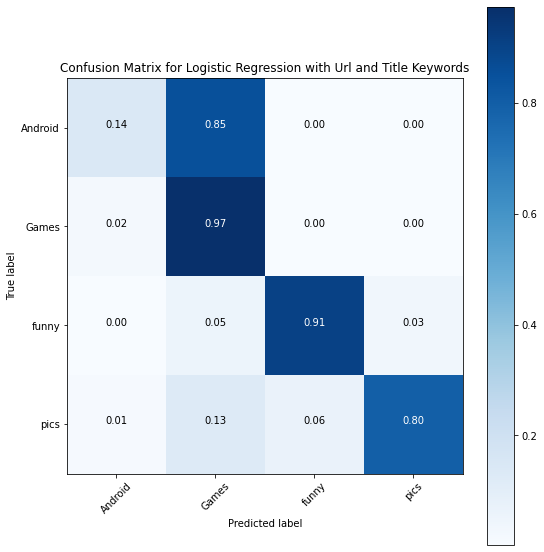

In [85]:
# plot for logistic regression confusion matrix with keyword feature set
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_logreg_X4, classes=['Android', 'Games', 'funny', 'pics'],
                      title='Confusion Matrix for Logistic Regression with Url and Title Keywords')

The results above between the keyword feature subset and full feature set are very similar. This indicates that the post_tags feature subset is insignificant to the logistic regression model. Therefore, we will not include the post_tags information in our feature set, for improved computational efficiency as well as reduced noise. 

## 3.3 Hyperparameter Tuning

In this section, we will look at hyperparameter tuning for the logistic regression model with one-vs-rest classifier and the keyword feature subset. 

We will use gridsearch (with 3-fold cv) to explor parameters including C, penalty, and solver. For the solver values, we will specifically explore 'lbfgs' as well as 'saga', where 'lbfgs' is the default solver. Comparatively, 'saga' is faster for larger datasets and works with both 'L1' and 'L2' regularization, whereas 'lbfgs' only works with 'L2' regularization and works well on smaller datasets. 

Note that the number as well as range of parameters are limited for reduced computational times.

In [0]:
#logistic regression hyperparameter tuning  
def logreg_Tuning(X_train, X_test, y_train, y_test):

  logreg = LogisticRegression(multi_class='ovr', max_iter=1000, n_jobs=-1)

  C = [1, 25, 50] 
  penalty = ['l1', 'l2']
  solver = ['lbfgs', 'saga']

  hyperparameters = dict(penalty=penalty, C=C, solver=solver) 

  #grid search with 3-fold cv
  grid = GridSearchCV(logreg, hyperparameters, cv=3, verbose=0)
  grid.fit(X_train, y_train)  

  #model training and metrics
  logreg_y_pred_train = grid.fit(X_train, y_train).predict(X_train)
  logreg_y_pred_test = grid.fit(X_train, y_train).predict(X_test)

  logreg_y_train_F1 = metrics.f1_score(y_train, logreg_y_pred_train, average='macro')
  logreg_y_test_F1 = metrics.f1_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_recall = metrics.recall_score(y_test, logreg_y_pred_test, average='macro')
  logreg_y_test_precision = metrics.precision_score(y_test, logreg_y_pred_test, average='macro')

  #combining metrics into a single dataframe
  results = {'LogReg': [logreg_y_train_F1, logreg_y_test_F1, logreg_y_test_recall, logreg_y_test_precision]}

  logreg_df = pd.DataFrame(results, index =['Train F1 Score', 'Test F1 Score', 'Test Recall', 'Test Precision']) 

  #confusion matrices for the three classifiers
  logreg_cm = confusion_matrix(y_test, logreg_y_pred_test, labels=data_clean['subreddit_encoded'].unique().tolist())

  #optimal hyperparameters for logreg
  print('Optimal Hyperparameters for Logistic Regression:\n', grid.best_estimator_)

  return logreg_df, logreg_cm

In [87]:
logreg_optimal_df, logreg_optimal_cm = logreg_Tuning(X4_train, X4_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_se

Optimal Hyperparameters for Logistic Regression:
 LogisticRegression(C=25, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='ovr', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


The optimal parameters found using grid search are the following:

   -  C = 25
   -  solver = 'saga'
   -  penalty = 'l1'

In [88]:
# logistic regression performance after tuning
logreg_optimal_df

,LogReg
Train F1 Score,0.721300
Test F1 Score,0.714671
Test Recall,0.705121
Test Precision,0.811655


In [89]:
# logistic regression performance before tuning
logreg_df_X4

,LogReg (X4)
Train F1 Score,0.718891
Test F1 Score,0.714311
Test Recall,0.704652
Test Precision,0.814617


Normalized confusion matrix
[[0.14381271 0.85117057 0.00167224 0.00334448]
 [0.02051621 0.97236929 0.00231635 0.00479815]
 [0.00424328 0.05374823 0.90735502 0.03465347]
 [0.01221374 0.12824427 0.06259542 0.79694656]]


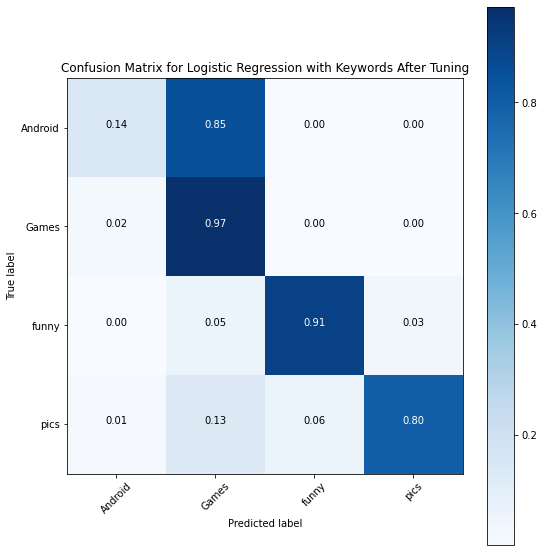

In [90]:
# plot for logistic regression after hyperparameter tuning
plt.figure(figsize=(8,8))
plot_confusion_matrix(logreg_optimal_cm, classes=['Android', 'Games', 'funny', 'pics'],
                      title='Confusion Matrix for Logistic Regression with Keywords After Tuning')

The performance of the logistic regression model with optimal parameters are very similar across all metrics to those before tuning. This is likely due to the fact that the parameters explore are constrained (for efficiency purposes). 

Overall the logistic regression model with OVR is able to achieve a recall score of around 0.7, with other metrics being within the same range. This sugggest that the model has good generalization and is not greatly influenced by the data imbalance. 

The model struggles when it comes to distinguishing between the classes of 'Android' and 'Games', which is likely caused by many factors such as:

  - similar class sizes (both are minority classes)
  - similar contents shared by the two classes (e.g. mobile gaming)
  - the ovr algorithm as the name suggest is good at comparing one class to the other classes as a whole, and is not very good when it comes to comparing individual classes (which can be done with multinomial, though not without tradeoffs for multiclass classification)

# Part 4: Sentiment Analysis

## a) Calculating Vader Score of Titles for Each Post 

We will first analyze the sentiment of each post title by calculating their corresponding vader compound scores (between 1 and -1), where 1 is most extreme positive, and -1 is most extreme negative.

In [0]:
# Use vader to evaluated sentiment of titles
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []

    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [92]:
titleDF = evalSentences(titles, to_df=True, columns=['titleCol','vader'])

100%|██████████| 33022/33022 [00:04<00:00, 8070.57it/s]


In [93]:
titleDF.head()

,titleCol,vader
0,"In 1964, an average wage worker had to clock 8...",0.4404
1,Here’s a reminder to grab one of these for a b...,0.0000
2,My best photo of 2018!,0.6696
3,Have a happy 2019 you sexy people!,0.8122
4,Adult male polar bear. Photo: Paul Nicklen,0.0000


## b) Analyzing Sentiment Distributions for the 4 Subreddits

In [0]:
#combining vader scores with original df
sentDF = pd.concat([data.reset_index(), titleDF], axis=1)

In [0]:
#getting vader scores for posts belonging to each subreddit 
funny_sent = sentDF.loc[sentDF['subreddit'] == 'funny']['vader']
pics_sent = sentDF.loc[sentDF['subreddit'] == 'pics']['vader']
android_sent = sentDF.loc[sentDF['subreddit'] == 'Android']['vader']
games_sent = sentDF.loc[sentDF['subreddit'] == 'Games']['vader']

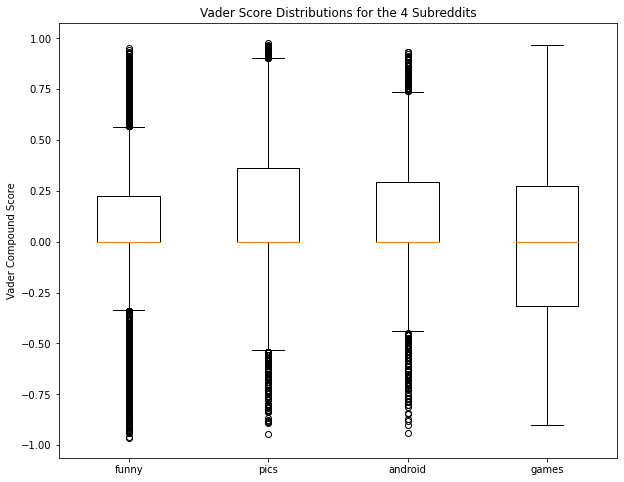

In [96]:
# plotting box plot of vader distribution for each of the 4 subreddit
subreddit_sent = [funny_sent, pics_sent, android_sent, games_sent]

plt.figure(figsize=(10,8))
plt.boxplot(subreddit_sent)
plt.xticks([1, 2, 3, 4], ['funny', 'pics', 'android', 'games'])
plt.ylabel('Vader Compound Score')
plt.title('Vader Score Distributions for the 4 Subreddits')
plt.show()

From the boxplot above, we can see that all 4 subreddits have average scores of around 0. For three out of the four subreddits (funny, pics, and android), the sentiment values are skewed towards positive. For the games subreddit, the distribution of positive and negative sentiments are fairly even, mostly falling within 0.25 and -0.25.

In terms of the outliers, all subreddits (except for games)have wider distributions of outliers in the negative region  than in the positive region. The funny subreddit has the widest distribution of outliers in both positive and negative regions. Unsurprisingly, the funny subreddit is also the majority class, significant outnumbering the other subreddits in terms of the number of posts.  

It can be said that the title contents of all four subreddits generally carry positive sentiments. In addition, it is more likely to come across a positive post that is extremely positive than a negative post that is extremely negative. 

## c) Defining Vader Score Threshold to Distinguish Between Clearly Positive and Negatives

Based on the results from the boxplot above, we will define the vader threshold as follows:

    - clearly positive: >0.75
    - clearly negative: <-0.4

Based on this threshold, we will assign sentiment labels (positive/negative) to posts and remove posts that do not fall within these regions (i.e. not clearly positive or negative)

In [0]:
# labelling positive, negative, and neutral sentiments of posts
sentDF['sentiment'] = ['positive' if vader > 0.75 else 'negative' if vader < -0.4 else 'neutral' for vader in sentDF['vader']]

In [0]:
# dropping neural posts
sentDF.drop(sentDF[sentDF['sentiment'] == 'neutral'].index, inplace = True)

In [99]:
sentDF.head(3)

,index,id,author,created_utc,subreddit,title,num_comments,score,selftext,url,day_of_week,day_night,hour,minute,viral,subreddit_encoded,url_type,titleCol,vader,sentiment
3,14,abcvv8,[deleted],1546301042,pics,Have a happy 2019 you sexy people!,3,46,[deleted],https://i.redd.it/kphnhymddp721.jpg,2,1,12,04,False,3,1,Have a happy 2019 you sexy people!,0.8122,positive
8,47,abcyee,itsahardg,1546301494,funny,"No car, no problem",7,0,,https://v.redd.it/cmdi8cx9ep721,2,1,12,11,False,2,0,"No car, no problem",-0.7269,negative
21,116,abd3q0,AnosaurusRex,1546302428,pics,"My best picture of 2018, taken in the UK! Hope...",3,28,,https://i.redd.it/vkq75ishhp721.jpg,2,1,12,27,False,3,1,"My best picture of 2018, taken in the UK! Hope...",0.9273,positive


## d) Analyzing Top Words in Each Subreddit For Positive and Negative Posts

Based on the sentiment labels as defined above, we will analyze and evaluate top words based on word frequency in positive and negative posts for each subreddit. 

In [0]:
# only need these columns for this analysis
analysisDF = sentDF[['titleCol', 'sentiment', 'subreddit']]

In [101]:
analysisDF.head()

,titleCol,sentiment,subreddit
3,Have a happy 2019 you sexy people!,positive,pics
8,"No car, no problem",negative,funny
21,"My best picture of 2018, taken in the UK! Hope...",positive,pics
48,"Why not support iMessage effects, Android Mess...",negative,Android
67,The blaze that engulfed a family's home (my ho...,negative,pics


In [0]:
# get top k words for a sentiment label and subreddit
def getTopK(df, k, label_value, sub_value, label_column='sentiment', 
            sub_column='subreddit', operation=operator.eq, value_column='titleCol'):
    
    stop = set(stopwords.words('english'))

    counter = Counter()

    for title in df.loc[df[sub_column] == sub_value].loc[operation(df[label_column],label_value)][value_column]:

            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(title, pattern='\w+')
                            if word.lower() not in stop and len(word) > 2])
            
    topk = counter.most_common(k)
    return topk

In [0]:
# getting top 30 positive words for each subreddit
topkPos_funny = getTopK(df=analysisDF, k=30, label_value='positive', sub_value='funny')
topkPos_pics = getTopK(df=analysisDF, k=30, label_value='positive', sub_value='pics')
topkPos_games = getTopK(df=analysisDF, k=30, label_value='positive', sub_value='Games')
topkPos_android = getTopK(df=analysisDF, k=30, label_value='positive', sub_value='Android')

topkPos_subreddits = [topkPos_funny, topkPos_pics, topkPos_games, topkPos_android]
subreddits = ['funny', 'pics', 'Games', 'Android']

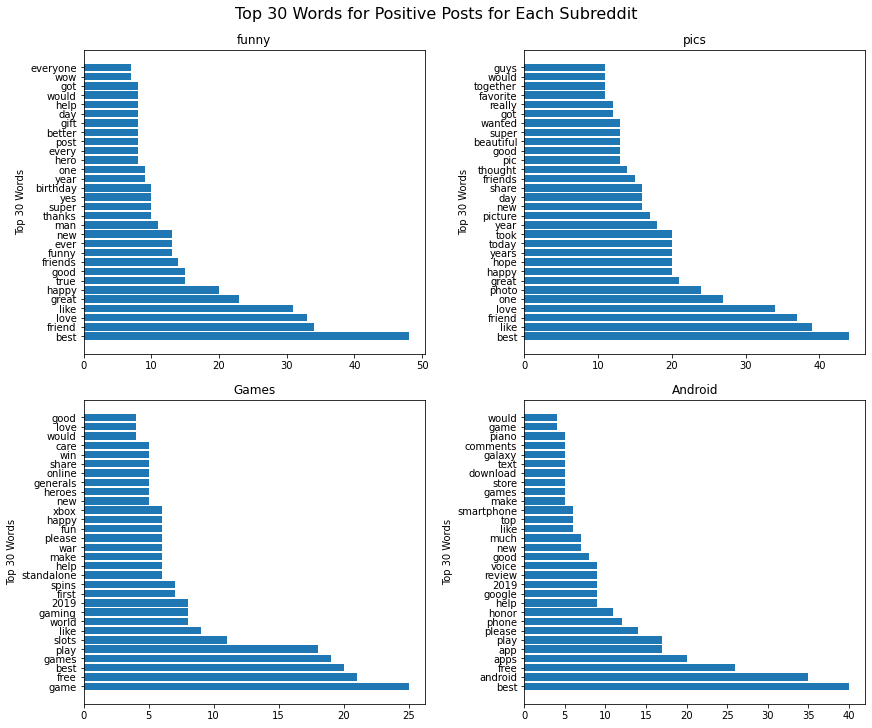

In [104]:
# plotting top words in positive posts for each subreddit
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(12,10))
i=0
for row in ax:
    for col in row:
        words = [sub[0] for sub in topkPos_subreddits[i]]
        counts = [sub[1] for sub in topkPos_subreddits[i]]
        col.barh(words, counts)
        col.set_title(subreddits[i])
        col.set_ylabel('Top 30 Words')
        
        i+=1

fig.suptitle('Top 30 Words for Positive Posts for Each Subreddit', fontsize=16)
plt.show()

As seen in the positive word plots above, we can see that all plot share positive words such as 'best' and 'like'. In addition, the subreddit label for each subreddit is seen in the top positive words (e.g. 'game' is the number one word for the games subreddit), together with words that are indicative of the subreddit (e.g. 'smartphone' for the android subreddit).

In [0]:
# getting top 30 negative words for each subreddit
topkNeg_funny = getTopK(df=analysisDF, k=30, label_value='negative', sub_value='funny')
topkNeg_pics = getTopK(df=analysisDF, k=30, label_value='negative', sub_value='pics')
topkNeg_games = getTopK(df=analysisDF, k=30, label_value='negative', sub_value='Games')
topkNeg_android = getTopK(df=analysisDF, k=30, label_value='negative', sub_value='Android')

topkNeg_subreddits = [topkNeg_funny, topkNeg_pics, topkNeg_games, topkNeg_android]

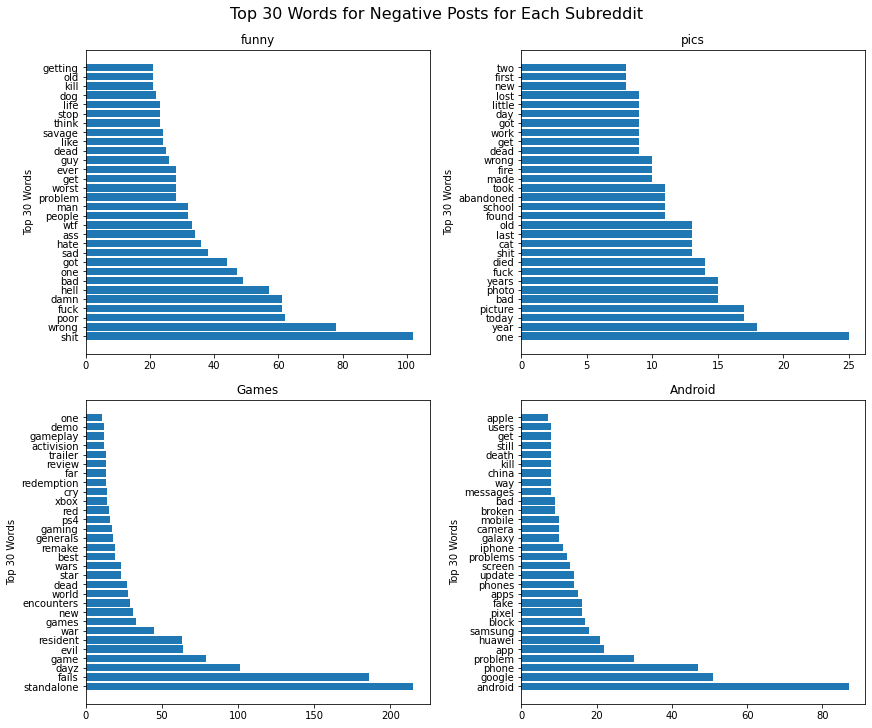

In [106]:
# plotting top words in negative posts for each subreddit
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(12,10))

i=0
for row in ax:
    for col in row:
        words = [sub[0] for sub in topkNeg_subreddits[i]]
        counts = [sub[1] for sub in topkNeg_subreddits[i]]
        col.barh(words, counts)
        col.set_title(subreddits[i])
        col.set_ylabel('Top 30 Words')
        
        i+=1

fig.suptitle('Top 30 Words for Negative Posts for Each Subreddit', fontsize=16)
plt.show()

Similar to the positive top words, the ranking of negative words as shown is heavily influenced by words that are common for each subreddit (e.g. 'google' for the android subreddit). This suggests that the ranking these top words (positive and negative) have limited information with regards to the sentiment of the subreddit, and is influenced greatly by the general frequency of the word (i.e. words that appear frequently in both positive and negative posts). 

Next, let's rank the top words based on Mutual Information as a metric instead of word frequency. Mutual information can measure similarities between a word column and the sentiment column, and should give us a good idea on how informative a word is with regards to a specific sentiment. 

To carry out the MI analysis, we will use two sets of top words (positive and negative) as define previously, and analyze separately for each subreddit class. 

In [0]:
# forming df of top 30 frequent terms for each subreddit
def dataFrameTransformation(analysisDF, topk):

    titles = analysisDF['titleCol'].tolist()
    
    stop = set(stopwords.words('english'))      
    
    #Find out if a particular title has the word from topk list
    freqTitle = []
    for title in titles:
        tempCounter = Counter([word.lower() for word in tokenize.regexp.regexp_tokenize(title, pattern='\w+')])
        topkinTitle = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqTitle.append(topkinTitle)
        
    #Prepare freqTitleDf
    freqTitleDf = pd.DataFrame(freqTitle)
    dfName = []
    
    for c in topk:
        dfName.append(c[0])
    freqTitleDf.columns = dfName
    finaldf = pd.concat([analysisDF.reset_index(), freqTitleDf], axis=1)

    return finaldf

In [0]:
# df of top positive words for each subreddit
topkDF_pos_funny = dataFrameTransformation(analysisDF, topkPos_funny)
topkDF_pos_pics = dataFrameTransformation(analysisDF, topkPos_pics)
topkDF_pos_games = dataFrameTransformation(analysisDF, topkPos_games)
topkDF_pos_android = dataFrameTransformation(analysisDF, topkPos_android)

# df of top negative words for each subreddit
topkDF_neg_funny = dataFrameTransformation(analysisDF, topkNeg_funny)
topkDF_neg_pics = dataFrameTransformation(analysisDF, topkNeg_pics)
topkDF_neg_games = dataFrameTransformation(analysisDF, topkNeg_games)
topkDF_neg_android = dataFrameTransformation(analysisDF, topkNeg_android)

In [0]:
# get Top K mutual information terms from the dataframe
# 0 (no mutual information) and 1 (perfect correlation)
def getMI_subreddits(topk, df, label_column='sentiment'):

    miScore = []

    for word in topk:

      # computes mutual information between ground truth(pos/neg) and the word of interest
        miScore.append([word[0]] +
        [metrics.normalized_mutual_info_score(df[label_column], df[word[0]])])

    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']

    return miScoredf

In [0]:
# top positive words ranked by mutual information with sentiment columns
miScoredf_pos_funny = getMI_subreddits(topkPos_funny, topkDF_pos_funny)
miScoredf_pos_pics = getMI_subreddits(topkPos_pics, topkDF_pos_pics)
miScoredf_pos_games = getMI_subreddits(topkPos_games, topkDF_pos_games)
miScoredf_pos_android = getMI_subreddits(topkPos_android, topkDF_pos_android)

miScoredf_pos_subreddits = [miScoredf_pos_funny, miScoredf_pos_pics, miScoredf_pos_games, miScoredf_pos_android]

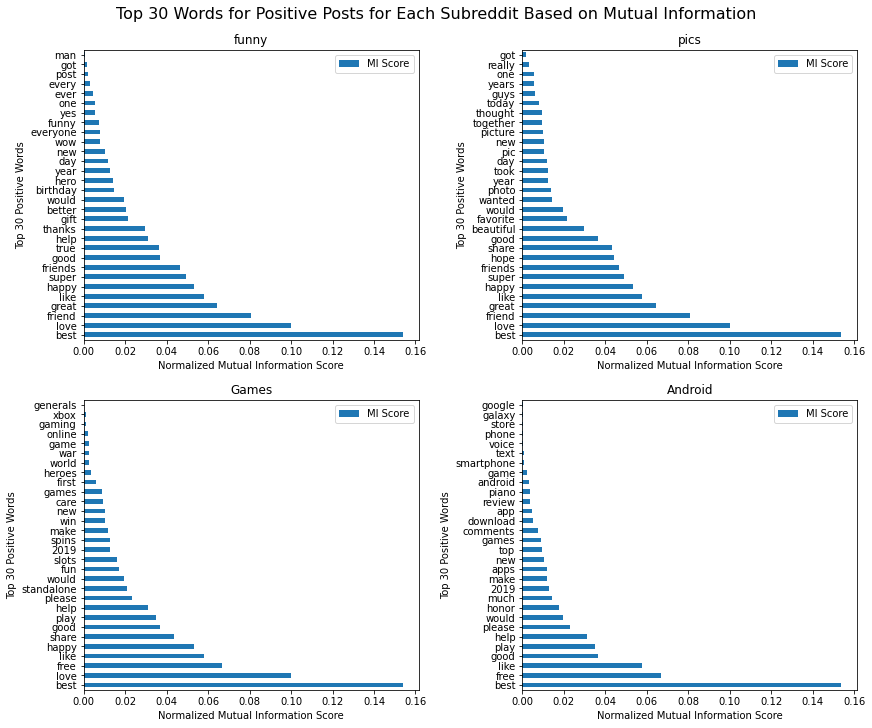

In [111]:
# plotting top words in positive posts for each subreddit
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(12,10))
i=0
for row in ax:
    for col in row:

        index = miScoredf_pos_subreddits[i]['Word'].tolist()
        miScoredf_pos_subreddits[i].index = index
        miScoredf_pos_subreddits[i].plot(kind='barh', figsize=(12, 10), ax=col)
        col.set_title(subreddits[i])
        col.set_xlabel('Normalized Mutual Information Score')
        col.set_ylabel('Top 30 Positive Words')

        i+=1

fig.suptitle('Top 30 Words for Positive Posts for Each Subreddit Based on Mutual Information', fontsize=16)
plt.show()

In [0]:
# top negative words ranked by mutual information with sentiment columns
miScoredf_neg_funny = getMI_subreddits(topkNeg_funny, topkDF_neg_funny)
miScoredf_neg_pics = getMI_subreddits(topkNeg_pics, topkDF_neg_pics)
miScoredf_neg_games = getMI_subreddits(topkNeg_games, topkDF_neg_games)
miScoredf_neg_android = getMI_subreddits(topkNeg_android, topkDF_neg_android)

miScoredf_neg_subreddits = [miScoredf_neg_funny, miScoredf_neg_pics, miScoredf_neg_games, miScoredf_neg_android]

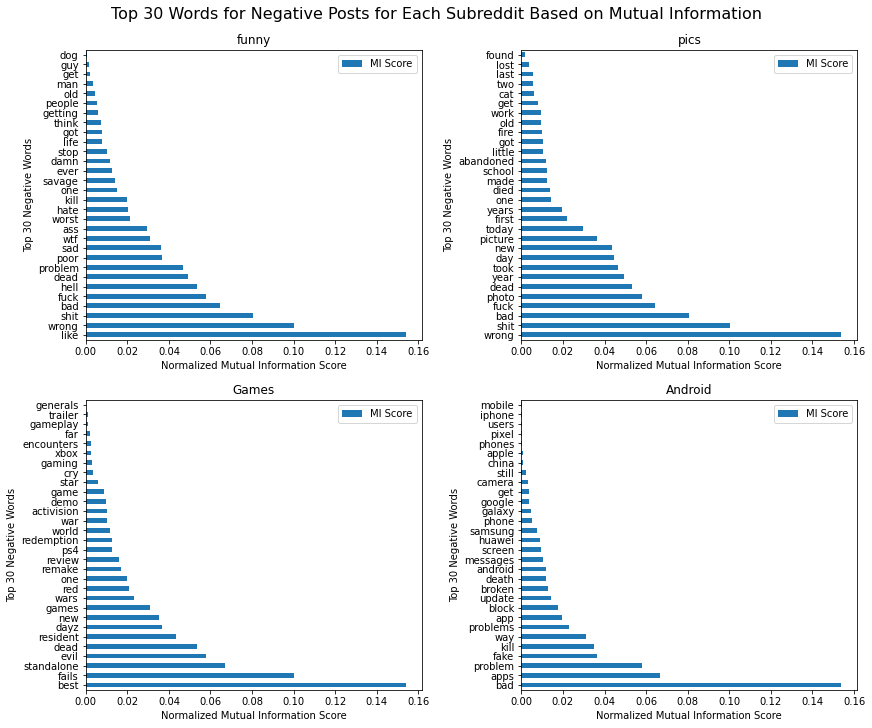

In [113]:
# plotting top words in positive posts for each subreddit
fig, ax = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(12,10))
i=0
for row in ax:
    for col in row:

        index = miScoredf_neg_subreddits[i]['Word'].tolist()
        miScoredf_pos_subreddits[i].index = index
        miScoredf_pos_subreddits[i].plot(kind='barh', figsize=(12, 10), ax=col)
        col.set_title(subreddits[i])
        col.set_xlabel('Normalized Mutual Information Score')
        col.set_ylabel('Top 30 Negative Words')

        i+=1

fig.suptitle('Top 30 Words for Negative Posts for Each Subreddit Based on Mutual Information', fontsize=16)
plt.show()

As seen in both sub-plots (positive and negative) above, we can see that the ranking of the top words are much more reflective of their corresponding sentiments, as opposed to their subreddit classes. Words that are more frequent in a subreddit but do not carry sentimental value (e.g. 'phones' for the android subreddit) are ranked lower by mutual information, unlike the previous attempt using only word frequency. As such, mutual information should be used for the sentiment analysis of top words